# Predcition of Hospital Admission Related to Otitis Externa

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to otitis externa (ot_externa).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [3]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [4]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [5]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'ot_externa_date_'+str(i), 'ot_externa_ab_date_'+str(i), 'ot_externa_ab_type_'+str(i),
                   'incdt_ot_externa_date_'+str(i), 'admitted_ot_externa_date_'+str(i), 'sgss_gp_cov_ot_externa_date_'+str(i)]]
    
    #drop rows with no ot_externa reord
    datum = datum[datum['ot_externa_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with ot_externa_i
    datum = datum[datum['sgss_gp_cov_ot_externa_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'ot_externa_date_'+str(i): 'ot_externa_date', 'ot_externa_ab_date_'+str(i): 'ot_externa_ab_date', 
                           'ot_externa_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_ot_externa_date_'+str(i): 'incdt_ot_externa_date', 'incdt_ot_externa_type_'+str(i): 'incdt_ot_externa_type',
                           'admitted_ot_externa_date_'+str(i): 'admitted_ot_externa_date',
                           'sgss_gp_cov_ot_externa_date_'+str(i): 'sgss_gp_cov_ot_externa_date'},
                inplace=True)
    
    return datum

In [6]:
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    # data_req = data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit',
    #              'event_ot_externa_admitted', 'duration_ot_externa_admitted']]
    data_req = data[vars+vars_countinuous+vars_output]

    # encoding categorical data for CPH
    # data_enc = data_req[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    data_enc = data_req[vars+vars_countinuous].reset_index()
    # data_enc

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_enc)
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [7]:
def make_summary_table(infection, infection_type, data):
    #summary table
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'
    # summary_table

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [8]:
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    # encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()
    # data_hosped

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_hosped)
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    # data_hosped_enc#.head()
    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'
    # summary_table_hosped

    # save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [9]:
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [10]:
def betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):

    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    # covariates.shape

    # save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    # transpose and sort covariates and coefficients
    covariatesT = covariates.T
    # covariatesT.covariate = covariates
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
    # covariatesT.shape

    # further cleaning up covariates to make them compatible with the encoded data
    mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

    #match mylist (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(mylist)] 
    data = data.sort_index(axis = 1) #sort 
    # data.shape

    # multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')
    # betas

    # sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    # sum_betas
#######################################################
    # predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas
    # sum_betas_hazard

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  
    # return sum_betas_hazard

    # sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
    # sum_betas_hazard

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
    # sum_betas_hazard

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
    # sum_betas_hazard_groupby

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    # separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
    # sum_betas_hazard_groupby.head()

    # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    # save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [11]:
def cph_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_train_cumulative_hazard

    # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_test_cumulative_hazard

    # plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    # plt.title('', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    # plt.tight_layout()
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [12]:
def cph_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']
    # prob_pred_true_train

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
    # prob_pred_true_train

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)
    # prob_pred_true_train

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
    # prob_pred_true_train_groupby_bin

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']
    # prob_pred_true_train_groupby_bin
############
    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']
    # prob_pred_true_test_groupby_bin
###################
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [13]:
def cph_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    # calculate concordance index, AUROC, and Brier score of cph model
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    # save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [14]:
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ot_externa_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [15]:
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [16]:
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ot_externa_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ot_externa_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [18]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_ot_externa.csv.gz')

data.shape

(200000, 224)

In [19]:
# save model outputs
a = open("../output/hospitalisation_prediction_ot_externa/data_ot_externa_record_cph_ot_externa.txt", "w")
a.write("")
a.writelines(['data_ot_externa_1 #with a record, #with no record: %.0f' % (data['ot_externa_date_1'].notna().sum()), ', %.0f' % (data['ot_externa_date_1'].isna().sum()),
              '\ndata_ot_externa_2 #with a record, #with no record: %.0f' % (data['ot_externa_date_2'].notna().sum()), ', %.0f' % (data['ot_externa_date_2'].isna().sum()),
              '\ndata_ot_externa_3 #with a record, #with no record: %.0f' % (data['ot_externa_date_3'].notna().sum()), ', %.0f' % (data['ot_externa_date_3'].isna().sum()),
              '\ndata_ot_externa_4 #with a record, #with no record: %.0f' % (data['ot_externa_date_4'].notna().sum()), ', %.0f' % (data['ot_externa_date_4'].isna().sum()),
              '\ndata_ot_externa_5 #with a record, #with no record: %.0f' % (data['ot_externa_date_5'].notna().sum()), ', %.0f' % (data['ot_externa_date_5'].isna().sum()),
              '\ndata_ot_externa_6 #with a record, #with no record: %.0f' % (data['ot_externa_date_6'].notna().sum()), ', %.0f' % (data['ot_externa_date_6'].isna().sum()),
              '\ndata_ot_externa_7 #with a record, #with no record: %.0f' % (data['ot_externa_date_7'].notna().sum()), ', %.0f' % (data['ot_externa_date_7'].isna().sum()),
              '\ndata_ot_externa_8 #with a record, #with no record: %.0f' % (data['ot_externa_date_8'].notna().sum()), ', %.0f' % (data['ot_externa_date_8'].isna().sum()),
              '\ndata_ot_externa_9 #with a record, #with no record: %.0f' % (data['ot_externa_date_9'].notna().sum()), ', %.0f' % (data['ot_externa_date_9'].isna().sum()),
              '\ndata_ot_externa_10 #with a record, #with no record: %.0f' % (data['ot_externa_date_10'].notna().sum()), ', %.0f' % (data['ot_externa_date_10'].isna().sum()),
              '\ndata_ot_externa_11 #with a record, #with no record: %.0f' % (data['ot_externa_date_11'].notna().sum()), ', %.0f' % (data['ot_externa_date_11'].isna().sum()),
              '\ndata_ot_externa_12 #with a record, #with no record: %.0f' % (data['ot_externa_date_12'].notna().sum()), ', %.0f' % (data['ot_externa_date_12'].isna().sum()),
              '\ndata_ot_externa_13 #with a record, #with no record: %.0f' % (data['ot_externa_date_13'].notna().sum()), ', %.0f' % (data['ot_externa_date_13'].isna().sum()),
              '\ndata_ot_externa_14 #with a record, #with no record: %.0f' % (data['ot_externa_date_14'].notna().sum()), ', %.0f' % (data['ot_externa_date_14'].isna().sum()),
              '\ndata_ot_externa_15 #with a record, #with no record: %.0f' % (data['ot_externa_date_15'].notna().sum()), ', %.0f' % (data['ot_externa_date_15'].isna().sum()),
              '\ndata_ot_externa_16 #with a record, #with no record: %.0f' % (data['ot_externa_date_16'].notna().sum()), ', %.0f' % (data['ot_externa_date_16'].isna().sum()),
              '\ndata_ot_externa_17 #with a record, #with no record: %.0f' % (data['ot_externa_date_17'].notna().sum()), ', %.0f' % (data['ot_externa_date_17'].isna().sum()),
              '\ndata_ot_externa_18 #with a record, #with no record: %.0f' % (data['ot_externa_date_18'].notna().sum()), ', %.0f' % (data['ot_externa_date_18'].isna().sum()),
              '\ndata_ot_externa_19 #with a record, #with no record: %.0f' % (data['ot_externa_date_19'].notna().sum()), ', %.0f' % (data['ot_externa_date_19'].isna().sum()),
              '\ndata_ot_externa_20 #with a record, #with no record: %.0f' % (data['ot_externa_date_20'].notna().sum()), ', %.0f' % (data['ot_externa_date_20'].isna().sum()),
              ])

FileNotFoundError: [Errno 2] No such file or directory: '../output/hospitalisation_prediction_ot_externa/data_ot_externa_record_cph_ot_externa.txt'

### 1-2- additional variables
Calculating Charlson Comorbidity Index based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [ ]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

0.0     37133
1.0     36946
2.0     33043
3.0     24958
4.0     14871
6.0     12264
7.0     10006
5.0      8269
8.0      7871
9.0      5781
10.0     3418
11.0     1872
12.0     1352
13.0      887
14.0      580
15.0      340
16.0      231
17.0       93
18.0       31
19.0       30
20.0       16
21.0        7
23.0        1
Name: CCI, dtype: int64

## 2- data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- gathering data

In [ ]:
#read 20 ot_externas and concatenate them 
data_ot_externa_1 = proc_infec_data(data,1)
data_ot_externa_2 = proc_infec_data(data,2)
data_ot_externa_3 = proc_infec_data(data,3)
data_ot_externa_4 = proc_infec_data(data,4)
data_ot_externa_5 = proc_infec_data(data,5)
data_ot_externa_6 = proc_infec_data(data,6)
data_ot_externa_7 = proc_infec_data(data,7)
data_ot_externa_8 = proc_infec_data(data,8)
data_ot_externa_9 = proc_infec_data(data,9)
data_ot_externa_10 = proc_infec_data(data,10)
data_ot_externa_11 = proc_infec_data(data,11)
data_ot_externa_12 = proc_infec_data(data,12)
data_ot_externa_13 = proc_infec_data(data,13)
data_ot_externa_14 = proc_infec_data(data,14)
data_ot_externa_15 = proc_infec_data(data,15)
data_ot_externa_16 = proc_infec_data(data,16)
data_ot_externa_17 = proc_infec_data(data,17)
data_ot_externa_18 = proc_infec_data(data,18)
data_ot_externa_19 = proc_infec_data(data,19)
data_ot_externa_20 = proc_infec_data(data,20)

data_ot_externa = pd.concat([data_ot_externa_1, data_ot_externa_2, data_ot_externa_3, data_ot_externa_4, data_ot_externa_5, data_ot_externa_6, data_ot_externa_7, data_ot_externa_8, data_ot_externa_9, data_ot_externa_10, data_ot_externa_11, data_ot_externa_12, data_ot_externa_13, data_ot_externa_14, data_ot_externa_15, data_ot_externa_16, data_ot_externa_17, data_ot_externa_18, data_ot_externa_19, data_ot_externa_20])
data_ot_externa.reset_index(inplace=True, drop=True)
data_ot_externa.shape

(360061, 20)

### 2-2- add season, event, and duration variables
#### season

In [ ]:
# convert data types
data_ot_externa['ot_externa_date'] = data_ot_externa['ot_externa_date'].astype('datetime64[ns]')
data_ot_externa['admitted_ot_externa_date'] = data_ot_externa['admitted_ot_externa_date'].astype('datetime64[ns]')
data_ot_externa.died_date = data_ot_externa.died_date.astype('datetime64[ns]')
data_ot_externa.deregistered_date = data_ot_externa.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_ot_externa['date'] = data_ot_externa['ot_externa_date'] #gp_cons_ot_externa
data_ot_externa['date'] = data_ot_externa['date'].dt.strftime('%Y-%m')
print(f'min date: {data_ot_externa.date.min()}')
print(f'max date: {data_ot_externa.date.max()}')
print(f'length of data_ot_externa: {len(data_ot_externa)}')

min date: 2019-01
max date: 2022-11
length of data_ot_externa: 360061


In [ ]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_ot_externa with today's date in year and month
data_ot_externa = data_ot_externa[data_ot_externa['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_ot_externa = data_ot_externa[data_ot_externa['date'] != last_1_month_date_y_m]
data_ot_externa = data_ot_externa[data_ot_externa['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of ot_externa records
data_ot_externa['season'] = np.nan
data_ot_externa['date_month'] = pd.DatetimeIndex(data_ot_externa['date']).month

conditions = [
    (data_ot_externa['date_month'] >= 3) & (data_ot_externa['date_month'] <= 5),
    (data_ot_externa['date_month'] >= 6) & (data_ot_externa['date_month'] <= 8),
    (data_ot_externa['date_month'] >= 9) & (data_ot_externa['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_ot_externa['season'] = np.select(conditions, choices, default='winter')

print(data_ot_externa['season'].value_counts())
print(f'\nmin date: {data_ot_externa.date.min()}')
print(f'max date: {data_ot_externa.date.max()}')
print(f'length: {len(data_ot_externa)}')

spring    94307
summer    93310
winter    83660
autumn    68727
Name: season, dtype: int64

min date: 2019-01
max date: 2022-08
length: 340004


In [ ]:
data_ot_externa = data_ot_externa[data_ot_externa['date'] <= '2019-12']
# data_ot_externa = data_ot_externa[(data_ot_externa['date'] >= '2020-03') & (data_ot_externa['date']<= '2021-03')]
# data_ot_externa = data_ot_externa[data_ot_externa['date'] >= '2021-04']
# print(f'min date: {data_ot_externa.date.min()}')
# print(f'max date: {data_ot_externa.date.max()}')

In [ ]:
#add period variable
data_ot_externa.loc[(data_ot_externa['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_ot_externa.loc[((data_ot_externa['date'] >= '2020-01') & (data_ot_externa['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_ot_externa.loc[(data_ot_externa['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

NameError: name 'data_lrti' is not defined

#### event and duration

In [ ]:
#scenario 1
#not hosped (nothing happened)
#data_ot_externa = data_ot_externa[data_ot_externa['admitted_ot_externa_date'].notnull()]
data_ot_externa.loc[data_ot_externa['admitted_ot_externa_date'].isnull(), 'event_ot_externa_admitted'] = 0
data_ot_externa['event_ot_externa_admitted'].value_counts()

0.0    142866
Name: event_ot_externa_admitted, dtype: int64

In [ ]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_ot_externa['delta_ot_externa_admitted'] = (data_ot_externa['admitted_ot_externa_date'] - data_ot_externa['ot_externa_date']).dt.days
data_ot_externa['delta_ot_externa_admitted'] = (data_ot_externa['admitted_ot_externa_date'] - data_ot_externa['ot_externa_date']).dt.days #gp_cons_ot_externa
data_ot_externa.loc[((data_ot_externa['delta_ot_externa_admitted'] >= 0) & (data_ot_externa['delta_ot_externa_admitted'] <= 30)), 'event_ot_externa_admitted'] = 1
# data_ot_externa['event_ot_externa_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before ot_externa consultation, i.e. negative value for delta_ot_externa_admitted
data_ot_externa = data_ot_externa[~(data_ot_externa['delta_ot_externa_admitted'] < 0)]
data_ot_externa['delta_ot_externa_admitted'].value_counts()

190.0     60
14.0      59
25.0      57
131.0     56
1.0       55
          ..
1404.0     1
1394.0     1
1365.0     1
1342.0     1
1274.0     1
Name: delta_ot_externa_admitted, Length: 1387, dtype: int64

In [ ]:
#scenario 3
#censor died patients
data_ot_externa['delta_admitted_died'] = (data_ot_externa['died_date'] - data_ot_externa['admitted_ot_externa_date']).dt.days
data_ot_externa.loc[data_ot_externa['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_ot_externa.loc[data_ot_externa['delta_admitted_died'] >= 0, 'event_ot_externa_admitted'] = 0
data_ot_externa.loc[((data_ot_externa['delta_admitted_died'] >= 0) & (data_ot_externa['delta_admitted_died'] <= 30)), 'event_ot_externa_admitted'] = 0
# data_ot_externa['event_ot_externa_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_ot_externa['delta_admitted_deregistered'] = (data_ot_externa['deregistered_date'] - data_ot_externa['admitted_ot_externa_date']).dt.days
data_ot_externa.loc[data_ot_externa['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_ot_externa.loc[data_ot_externa['delta_admitted_deregistered'] >= 0, 'event_ot_externa_admitted'] = 0
data_ot_externa.loc[((data_ot_externa['delta_admitted_deregistered'] > 0) & (data_ot_externa['delta_admitted_deregistered'] <= 30)), 'event_ot_externa_admitted'] = 0
# data_ot_externa['event_ot_externa_admitted'].value_counts()

#agg scenario 3s
data_ot_externa['delta_admitted_died_deregistered'] = data_ot_externa['delta_admitted_deregistered'].combine_first(data_ot_externa['delta_admitted_died'])
data_ot_externa.loc[data_ot_externa['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_ot_externa['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

171962

In [ ]:
#scenario 1
#any other patients (nothing happened)
data_ot_externa['event_ot_externa_admitted'] = data_ot_externa['event_ot_externa_admitted'].replace(np.NaN, 0)
data_ot_externa['event_ot_externa_admitted'].value_counts()

0.0    173693
1.0      1425
Name: event_ot_externa_admitted, dtype: int64

In [ ]:
#assign values for duration column
data_ot_externa['duration_ot_externa_admitted'] = data_ot_externa['delta_ot_externa_admitted'].combine_first(data_ot_externa['delta_admitted_died_deregistered'])
data_ot_externa['duration_ot_externa_admitted'] = data_ot_externa['duration_ot_externa_admitted'].replace(np.NaN, 30)
data_ot_externa.loc[(data_ot_externa['duration_ot_externa_admitted'] > 30), 'duration_ot_externa_admitted'] = 30
data_ot_externa['duration_ot_externa_admitted'].value_counts()

30.0    173740
14.0        59
25.0        57
1.0         55
3.0         55
7.0         53
28.0        52
21.0        51
18.0        51
11.0        51
15.0        50
6.0         48
27.0        48
19.0        48
13.0        47
2.0         46
9.0         46
23.0        45
16.0        45
0.0         43
20.0        43
4.0         42
8.0         42
26.0        40
12.0        39
17.0        39
10.0        38
22.0        37
24.0        37
29.0        36
5.0         35
Name: duration_ot_externa_admitted, dtype: int64

In [ ]:
# give value 1 to event_ot_externa_admitted if duration_ot_externa_admitted is greater or equal to 0 and less than 30
data_ot_externa.loc[((data_ot_externa['duration_ot_externa_admitted'] >= 0) & (data_ot_externa['duration_ot_externa_admitted'] < 30)), 'event_ot_externa_admitted'] = 1
data_ot_externa['event_ot_externa_admitted'].value_counts()

0.0    173690
1.0      1428
Name: event_ot_externa_admitted, dtype: int64

In [ ]:
#drop any rows with value 0 in duration column
data_ot_externa = data_ot_externa[~(data_ot_externa['duration_ot_externa_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_ot_externa.loc[((data_ot_externa['delta_ot_externa_admitted'] > 0) & (data_ot_externa['delta_ot_externa_admitted'] < 30)), 'event_ot_externa_admitted'] = 1

In [ ]:
# data_ot_externa[data_ot_externa['duration_ot_externa_admitted']==0][['delta_ot_externa_admitted', 'ot_externa_date', 'gp_cons_ot_externa', 'admitted_ot_externa_date', 'delta_ot_externa_admitted', 'delta_admitted_died_deregistered', 'event_ot_externa_admitted', 'duration_ot_externa_admitted']]
# data_ot_externa.loc[151:200, ['event_ot_externa_admitted', 'duration_ot_externa_admitted']]
# data_ot_externa.loc[201:250, ['event_ot_externa_admitted', 'duration_ot_externa_admitted']].sort_values(by=['duration_ot_externa_admitted'])
data_ot_externa[['event_ot_externa_admitted', 'duration_ot_externa_admitted']].sort_values(by=['duration_ot_externa_admitted'])

,event_ot_externa_admitted,duration_ot_externa_admitted
112677,1.0,1.0
135125,1.0,1.0
174996,1.0,1.0
37559,1.0,1.0
71358,1.0,1.0
...,...,...
72313,0.0,30.0
72314,0.0,30.0
72315,0.0,30.0
72303,0.0,30.0


### 2-3- dealing with uninteresting and missing values

In [ ]:
# prep before plot
data_ot_externa['age'][data_ot_externa['age'] < 0] = np.nan
data_ot_externa = data_ot_externa[data_ot_externa['age_cat'] != '0-4']
data_ot_externa = data_ot_externa[data_ot_externa['age_cat'] != '5-14']
# drop anybody with age less than 18
data_ot_externa = data_ot_externa[~(data_ot_externa['age'] < 18)]  
print(f'Min age: {data_ot_externa.age.min()}')

## remove died cases
#data_ot_externa.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_ot_externa['bmi'][data_ot_externa['bmi'] < 10] = 0
# replace 0s with nans
data_ot_externa['bmi'] = data_ot_externa['bmi'].replace({0:np.nan})

# remove cases with negative antibacterial_brit
data_ot_externa['antibacterial_brit'][data_ot_externa['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [ ]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_ot_externa = data_ot_externa.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_ot_externa = data_ot_externa.replace({"smoking_status": dict_smoking})

In [ ]:
if ('region' in data_ot_externa.columns) and (data_ot_externa['region'].isnull().sum() > 0):
    # drop region value missing
    # data_ot_externa['region_imp'] = data_ot_externa['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_ot_externa.region.isnull().sum()}')
    data_ot_externa = data_ot_externa[data_ot_externa['region'].notna()]

print(f'Cound of missing values in variable region: {data_ot_externa.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_ot_externa.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      21479
North West                  10795
South East                  10774
South West                  10609
West Midlands               10603
Yorkshire and The Humber    10584
North East                  10554
East Midlands               10500
East                        10392
Name: region, dtype: int64


In [ ]:
if ('antibacterial_brit' in data_ot_externa.columns) and (data_ot_externa['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_ot_externa.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_ot_externa.antibacterial_brit.mean():.3f}')
    data_ot_externa['antibacterial_brit'] = data_ot_externa['antibacterial_brit'].fillna(0)
    # data_ot_externa['antibacterial_brit'] = data_ot_externa['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_ot_externa.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_ot_externa.antibacterial_brit.mean():.3f}')

Cound of missing values in variable antibacterial_brit before changing NANs to zeros: 1
Mean of antibacterial_brit values before changing NAN to zeros: 1.243

Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.243


In [ ]:
if ('ethnicity' in data_ot_externa.columns) and (data_ot_externa['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_ot_externa.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_ot_externa.ethnicity.value_counts()}')
    # data_ot_externa['ethnicity'] = data_ot_externa['ethnicity'].astype(str)
    data_ot_externa['ethnicity'] = data_ot_externa['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_ot_externa.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_ot_externa.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 26629
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    64061
5.0     7824
3.0     7776
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    64061
0.0    26629
5.0     7824
3.0     7776
Name: ethnicity, dtype: int64


In [ ]:
if ('smoking_status' in data_ot_externa.columns) and (data_ot_externa['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_ot_externa.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_ot_externa.smoking_status.value_counts()}')
    # data_ot_externa['smoking_status'] = data_ot_externa['smoking_status'].astype(str)
    data_ot_externa['smoking_status'] = data_ot_externa['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_ot_externa.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_ot_externa.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 44025
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    41708
3.0    13693
2.0     6864
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    44025
1.0    41708
3.0    13693
2.0     6864
Name: smoking_status, dtype: int64


In [ ]:
if ('imd' in data_ot_externa.columns) and (data_ot_externa['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_ot_externa.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_ot_externa.imd.value_counts()}')
    # data_ot_externa['imd'] = data_ot_externa['imd'].astype(str)
    data_ot_externa['imd'] = data_ot_externa['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_ot_externa.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_ot_externa.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
4    20297
3    20294
2    20283
1    20197
5    20107
0     5112
Name: imd, dtype: int64


In [ ]:
data_ot_externa['bmi_cat'] = 5
col_bmi_cat = data_ot_externa.columns.get_loc('bmi_cat')

col_sex = data_ot_externa.columns.get_loc('sex')
col_age = data_ot_externa.columns.get_loc('age')
col_bmi = data_ot_externa.columns.get_loc('bmi')

for idx, x in enumerate(data_ot_externa['bmi_cat']):
    if data_ot_externa.iat[idx, col_bmi] >= 30:
        data_ot_externa.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_ot_externa.iat[idx, col_bmi] >= 25) and (data_ot_externa.iat[idx, col_bmi] < 30):
        data_ot_externa.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_ot_externa.iat[idx, col_bmi] >= 18.5) and (data_ot_externa.iat[idx, col_bmi] < 25):
        data_ot_externa.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_ot_externa.iat[idx, col_bmi] < 18.5:
        data_ot_externa.iat[idx, col_bmi_cat] = 4 #'Underweight'

data_ot_externa['bmi_cat'].value_counts()

1    55340
5    26856
2    11870
3     8673
4     3551
Name: bmi_cat, dtype: int64

In [ ]:
if ('bmi_cat' in data_ot_externa.columns) and (data_ot_externa['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_ot_externa.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_ot_externa.bmi_cat.value_counts()}')
    # data_ot_externa['bmi_cat'] = data_ot_externa['bmi_cat'].astype(str)
    data_ot_externa['bmi_cat'] = data_ot_externa['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_ot_externa.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_ot_externa.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    55340
5    26856
2    11870
3     8673
4     3551
Name: bmi_cat, dtype: int64


In [ ]:
#add variable ab_type_cat
#find ab types
ab_series = pd.value_counts(data_ot_externa.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_ot_externa['ab_type_cat'] = np.where(data_ot_externa['ab_type'].isin(ab_series[mask].index),'other',data_ot_externa['ab_type'])

#assign no to non ab users
data_ot_externa.loc[data_ot_externa['ot_externa_ab_date'].isnull(), 'ab_type_cat'] = 'no'

#fill nas with 0 and then assign other to 0s
data_ot_externa['ab_type_cat'] = data_ot_externa['ab_type_cat'].fillna(0)
data_ot_externa['ab_type_cat'].value_counts()

no             95556
0               8578
other           1285
Amoxicillin      652
Doxycycline      219
Name: ab_type_cat, dtype: int64

### 2-4- translate values of categorical variables

In [ ]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

In [ ]:
# reoplace values of dictionaries with existing ones
data_ot_externa = data_ot_externa.replace({"sex": dict_sex})
data_ot_externa = data_ot_externa.replace({"ethnicity": dict_ethnicity})
data_ot_externa = data_ot_externa.replace({"smoking_status": dict_smoking})
data_ot_externa = data_ot_externa.replace({"imd": dict_imd})
data_ot_externa = data_ot_externa.replace({"bmi_cat": dict_bmi})
data_ot_externa = data_ot_externa.replace({"flu_vaccine": dict_flu})
data_ot_externa = data_ot_externa.replace({"region": dict_region})
data_ot_externa = data_ot_externa.replace({"age_cat": dict_age})
data_ot_externa = data_ot_externa.replace({"ab_type_cat": dict_ab_type})
data_ot_externa['ab_type_cat'].value_counts()

no             95556
other           9863
Amoxicillin      652
Doxycycline      219
Name: ab_type_cat, dtype: int64

### 2-5- categorising and assigning max value for continuous variables

In [ ]:
# categorising
data_ot_externa['CCI_cat'] = pd.cut(data_ot_externa['CCI'], right=False, bins=[0,1,3,5,7,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_ot_externa['CCI_cat'].value_counts()

low          37410
medium       21368
very_low     19591
very_high    17220
high         10701
Name: CCI_cat, dtype: int64

In [ ]:
# assign max value to outliers (beyond 95 percentile)
data_ot_externa['antibacterial_brit'].clip(0, data_ot_externa['antibacterial_brit'].quantile(0.95), inplace=True)
data_ot_externa['antibacterial_brit'].max()

data_ot_externa['antibacterial_brit_cat'] = pd.cut(data_ot_externa['antibacterial_brit'], 3, labels=['low', 'medium', 'high'])
data_ot_externa['antibacterial_brit_cat'].value_counts()

low       61766
high      26242
medium    18282
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

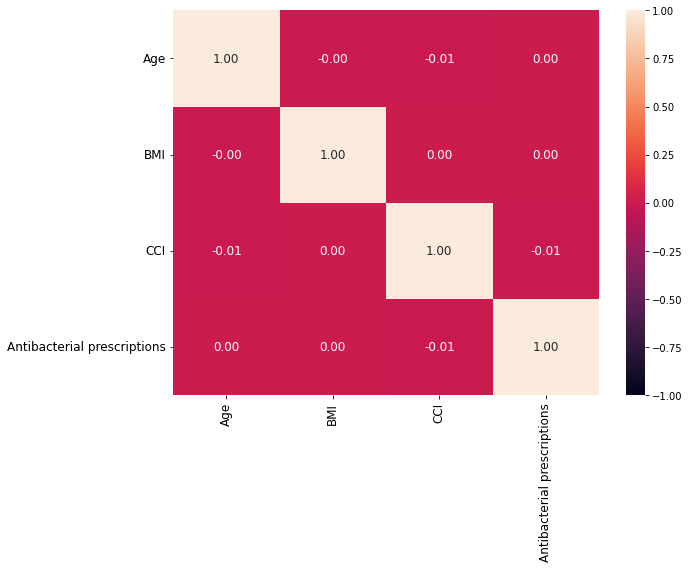

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_ot_externa[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/corr_ot_externa.jpg')
plt.show()

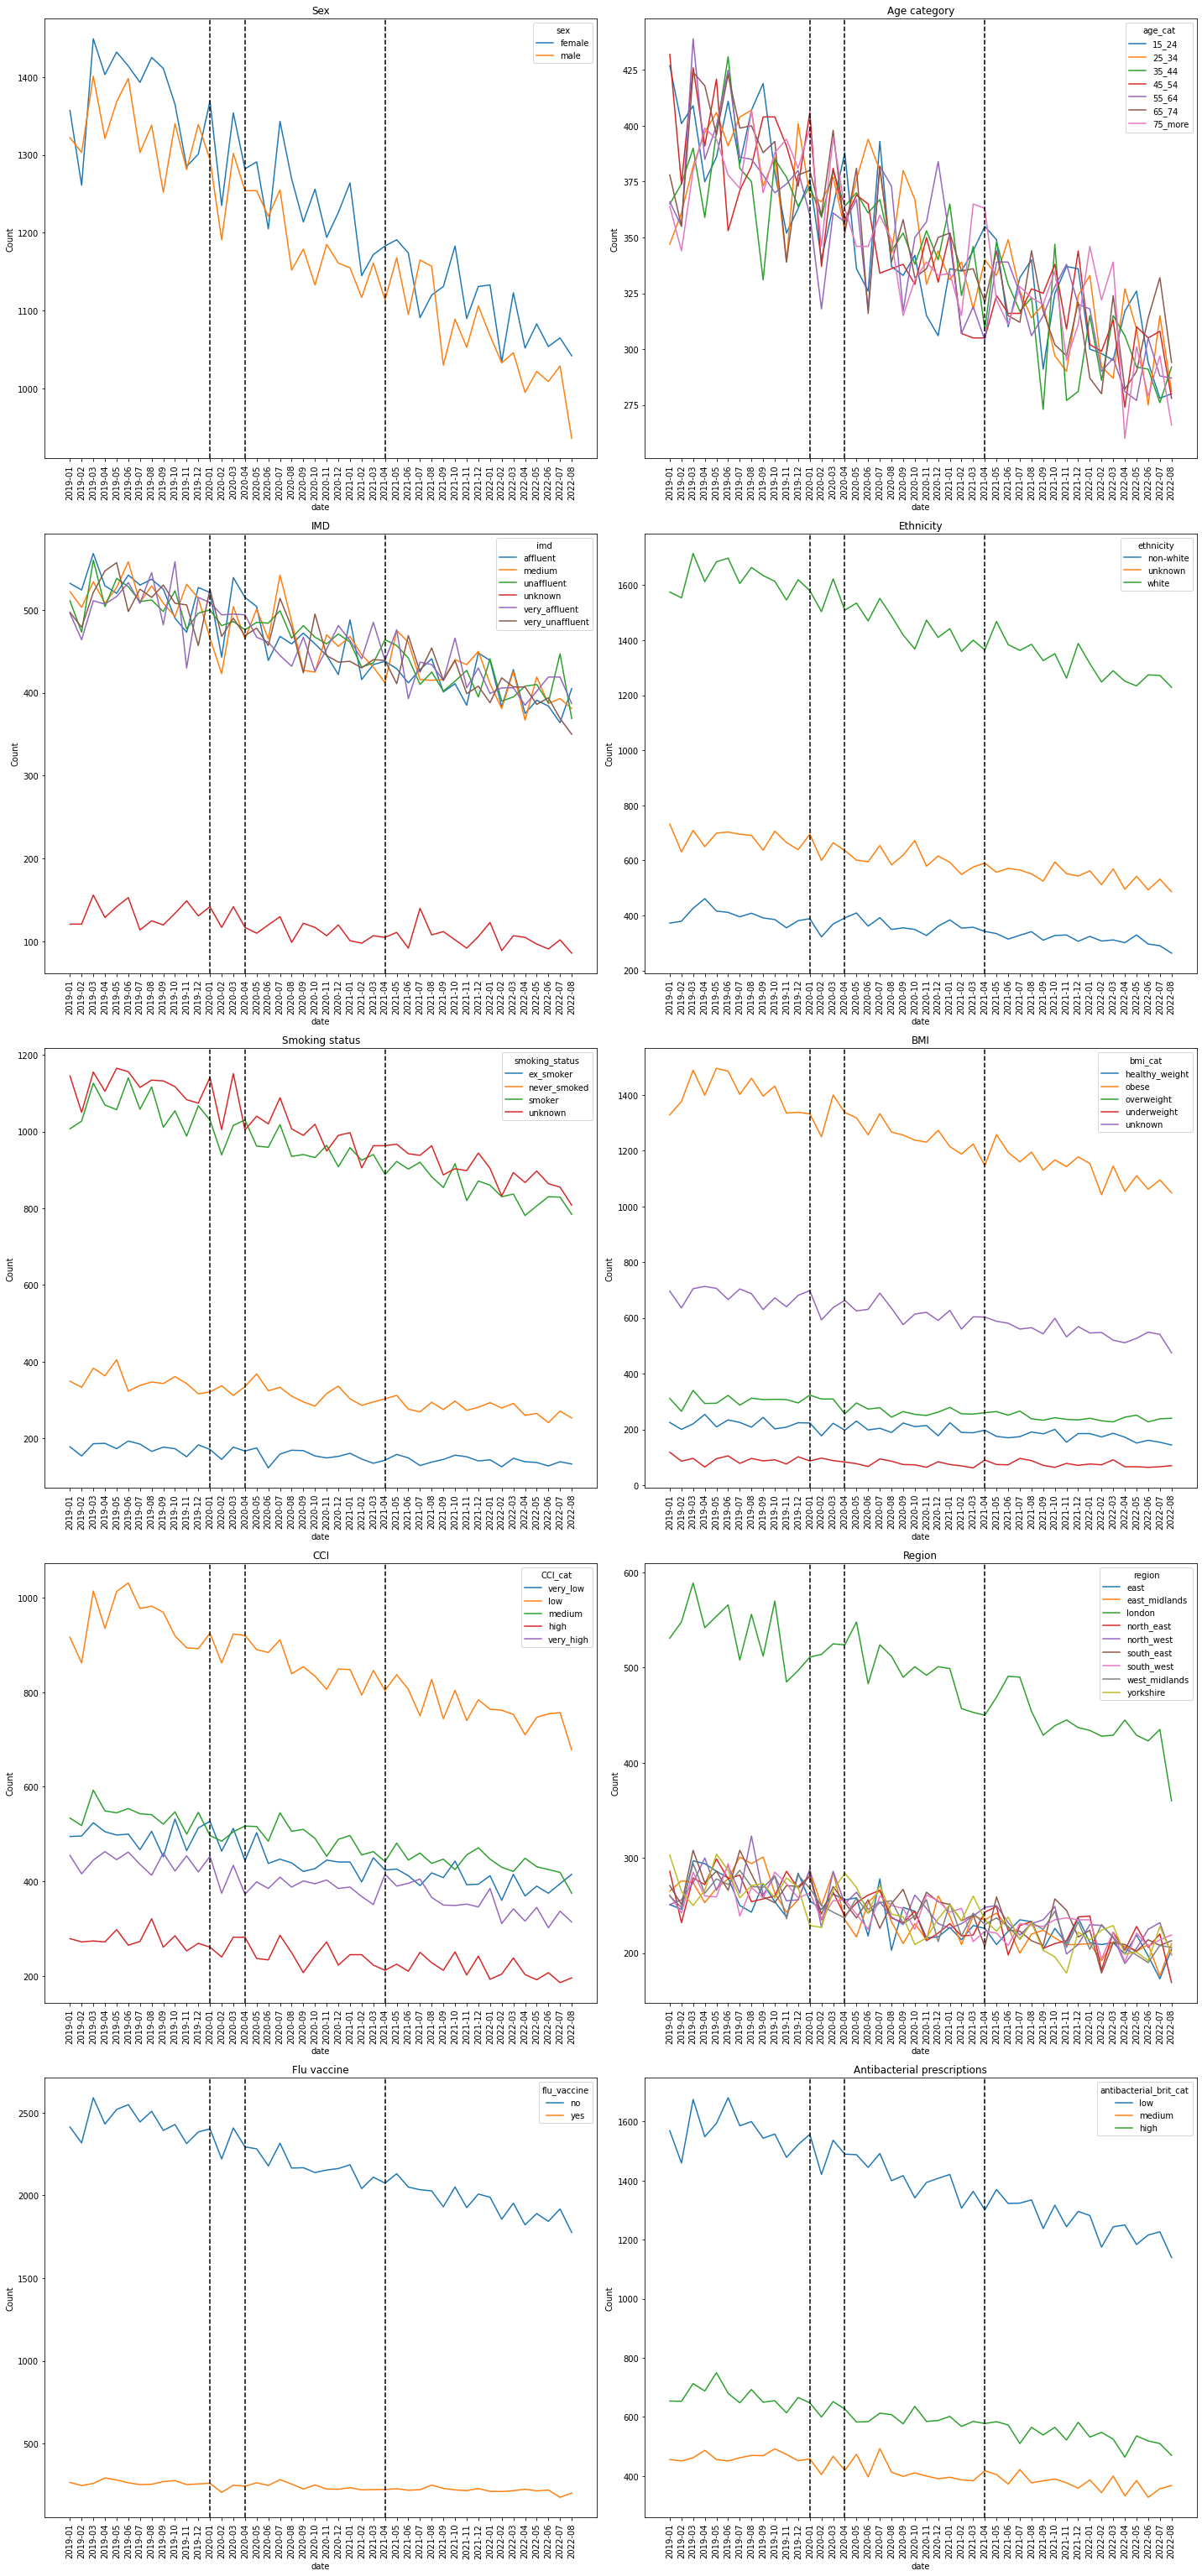

In [ ]:
fig, axes = plt.subplots(5,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_ot_externa, 'sex', 'Sex', axes[0,0])
create_lineplot(data_ot_externa, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_ot_externa, 'imd', 'IMD', axes[1,0])
create_lineplot(data_ot_externa, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_ot_externa, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_ot_externa, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_ot_externa, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_ot_externa, 'region', 'Region', axes[3,1])
create_lineplot(data_ot_externa, 'flu_vaccine', 'Flu vaccine', axes[4,0])
create_lineplot(data_ot_externa, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[4,1])
# fig.delaxes(ax=axes[5,1])

# fig.suptitle('Risk Factors of ot_externa patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/risk_factors_cat_ot_externa.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics
We separate data of ot_externa to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [ ]:
data_ot_externa = data_ot_externa[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'ot_externa_ab_date', 'ab_type_cat', 'incdt_ot_externa_date', 'date', 'period',
                       'event_ot_externa_admitted', 'duration_ot_externa_admitted'
                        ]]

data_ot_externa.shape

(106290, 17)

In [ ]:
#incident and prevalent infection 
data_ot_externa_incdt = data_ot_externa[data_ot_externa['incdt_ot_externa_date'] == 0]
data_ot_externa_prevl = data_ot_externa[data_ot_externa['incdt_ot_externa_date'] == 1]
#switch variable ot_externa_ab_date into a binary variable
data_ot_externa_incdt[['ot_externa_ab_date']] = data_ot_externa_incdt[['ot_externa_ab_date']].where(data_ot_externa_incdt[['ot_externa_ab_date']].isnull(), 1).fillna(0).astype(int)
data_ot_externa_prevl[['ot_externa_ab_date']] = data_ot_externa_prevl[['ot_externa_ab_date']].where(data_ot_externa_prevl[['ot_externa_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_ot_externa_incdt_males = data_ot_externa_incdt[data_ot_externa_incdt['sex'] == 'male']
data_ot_externa_incdt_females = data_ot_externa_incdt[data_ot_externa_incdt['sex'] == 'female']
data_ot_externa_prevl_males = data_ot_externa_prevl[data_ot_externa_prevl['sex'] == 'male']
data_ot_externa_prevl_females = data_ot_externa_prevl[data_ot_externa_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_ot_externa_incdt_15_24 = data_ot_externa_incdt[data_ot_externa_incdt['age_cat'] == '15_24']
data_ot_externa_incdt_25_34 = data_ot_externa_incdt[data_ot_externa_incdt['age_cat'] == '25_34']
data_ot_externa_incdt_35_44 = data_ot_externa_incdt[data_ot_externa_incdt['age_cat'] == '35_44']
data_ot_externa_incdt_45_54 = data_ot_externa_incdt[data_ot_externa_incdt['age_cat'] == '45_54']
data_ot_externa_incdt_55_64 = data_ot_externa_incdt[data_ot_externa_incdt['age_cat'] == '55_64']
data_ot_externa_incdt_65_74 = data_ot_externa_incdt[data_ot_externa_incdt['age_cat'] == '65_74']
data_ot_externa_incdt_75_more = data_ot_externa_incdt[data_ot_externa_incdt['age_cat'] == '75_more']
data_ot_externa_prevl_15_24 = data_ot_externa_prevl[data_ot_externa_prevl['age_cat'] == '15_24']
data_ot_externa_prevl_25_34 = data_ot_externa_prevl[data_ot_externa_prevl['age_cat'] == '25_34']
data_ot_externa_prevl_35_44 = data_ot_externa_prevl[data_ot_externa_prevl['age_cat'] == '35_44']
data_ot_externa_prevl_45_54 = data_ot_externa_prevl[data_ot_externa_prevl['age_cat'] == '45_54']
data_ot_externa_prevl_55_64 = data_ot_externa_prevl[data_ot_externa_prevl['age_cat'] == '55_64']
data_ot_externa_prevl_65_74 = data_ot_externa_prevl[data_ot_externa_prevl['age_cat'] == '65_74']
data_ot_externa_prevl_75_more = data_ot_externa_prevl[data_ot_externa_prevl['age_cat'] == '75_more']

data_ot_externa_incdt_prepandemic = data_ot_externa_incdt[data_ot_externa_incdt['date'] <= '2019-12']
data_ot_externa_incdt_during_pandemic = data_ot_externa_incdt[(data_ot_externa_incdt['date'] >= '2020-03') & (data_ot_externa_incdt['date']<= '2021-03')]
data_ot_externa_incdt_post_2nd_lockdown = data_ot_externa_incdt[data_ot_externa_incdt['date'] <= '2021-04']
data_ot_externa_prevl_prepandemic = data_ot_externa_prevl[data_ot_externa_prevl['date'] <= '2019-12']
data_ot_externa_prevl_during_pandemic = data_ot_externa_prevl[(data_ot_externa_prevl['date'] >= '2020-03') & (data_ot_externa_prevl['date']<= '2021-03')]
data_ot_externa_prevl_post_2nd_lockdown = data_ot_externa_prevl[data_ot_externa_prevl['date'] <= '2021-04']

# #incident and prevalent infection stratified by ab categories
# data_ot_externa_incdt_abtype_0 = data_ot_externa_incdt[data_ot_externa_incdt['ab_type_cat'] == data_ot_externa['ab_type_cat'].unique()[0]]
# data_ot_externa_incdt_abtype_1 = data_ot_externa_incdt[data_ot_externa_incdt['ab_type_cat'] == data_ot_externa['ab_type_cat'].unique()[1]]
# data_ot_externa_incdt_abtype_2 = data_ot_externa_incdt[data_ot_externa_incdt['ab_type_cat'] == data_ot_externa['ab_type_cat'].unique()[2]]
# data_ot_externa_incdt_abtype_3 = data_ot_externa_incdt[data_ot_externa_incdt['ab_type_cat'] == data_ot_externa['ab_type_cat'].unique()[3]]
# data_ot_externa_prevl_abtype_0 = data_ot_externa_prevl[data_ot_externa_prevl['ab_type_cat'] == data_ot_externa['ab_type_cat'].unique()[0]]
# data_ot_externa_prevl_abtype_1 = data_ot_externa_prevl[data_ot_externa_prevl['ab_type_cat'] == data_ot_externa['ab_type_cat'].unique()[1]]
# data_ot_externa_prevl_abtype_2 = data_ot_externa_prevl[data_ot_externa_prevl['ab_type_cat'] == data_ot_externa['ab_type_cat'].unique()[2]]
# data_ot_externa_prevl_abtype_3 = data_ot_externa_prevl[data_ot_externa_prevl['ab_type_cat'] == data_ot_externa['ab_type_cat'].unique()[3]]

# #incident and prevalent infection with antibiotics type
# data_ot_externa_incdt_abs = data_ot_externa_incdt[data_ot_externa_incdt['ot_externa_ab_date'] == 1]
# data_ot_externa_prevl_abs = data_ot_externa_prevl[data_ot_externa_prevl['ot_externa_ab_date'] == 1]

# no antibiotics and incident hospital admission
data_ot_externa_no_abs_incdt = data_ot_externa[data_ot_externa['ot_externa_ab_date'].isnull()] #gp_cons_ot_externa_ab
data_ot_externa_no_abs_incdt = data_ot_externa_no_abs_incdt[data_ot_externa_no_abs_incdt['incdt_ot_externa_date'] == 0]

# with antibiotics and incident hospital admission
data_ot_externa_abs_incdt = data_ot_externa[data_ot_externa['ot_externa_ab_date'].notnull()]
data_ot_externa_abs_incdt = data_ot_externa_abs_incdt[data_ot_externa_abs_incdt['incdt_ot_externa_date'] == 0]

# no antibiotics and prevalent hospital admission
data_ot_externa_no_abs_prevl = data_ot_externa[data_ot_externa['ot_externa_ab_date'].isnull()]
data_ot_externa_no_abs_prevl = data_ot_externa_no_abs_prevl[data_ot_externa_no_abs_prevl['incdt_ot_externa_date'] == 1]

# with antibiotics and prevalent hospital admission
data_ot_externa_abs_prevl = data_ot_externa[data_ot_externa['ot_externa_ab_date'].notnull()]
data_ot_externa_abs_prevl = data_ot_externa_abs_prevl[data_ot_externa_abs_prevl['incdt_ot_externa_date'] == 1]

print(f'shape of data_ot_externa_incdt: {data_ot_externa_incdt.shape}')
print(f'shape of data_ot_externa_prevl: {data_ot_externa_prevl.shape}')
print(f'shape of data_ot_externa_no_abs_incdt: {data_ot_externa_no_abs_incdt.shape}')
print(f'shape of data_ot_externa_abs_incdt: {data_ot_externa_abs_incdt.shape}')
print(f'shape of data_ot_externa_no_abs_prevl: {data_ot_externa_no_abs_prevl.shape}')
print(f'shape of data_ot_externa_abs_prevl: {data_ot_externa_abs_prevl.shape}')
print(f'\nvalue counts of data_ot_externa_no_abs_incdt: \n{data_ot_externa_no_abs_incdt.event_ot_externa_admitted.value_counts()}')
print(f'value counts of data_ot_externa_abs_incdt: \n{data_ot_externa_abs_incdt.event_ot_externa_admitted.value_counts()}')
print(f'value counts of data_ot_externa_no_abs_prevl: \n{data_ot_externa_no_abs_prevl.event_ot_externa_admitted.value_counts()}')
print(f'value counts of data_ot_externa_abs_prevl: \n{data_ot_externa_abs_prevl.event_ot_externa_admitted.value_counts()}')

shape of data_ot_externa_incdt: (95779, 17)
shape of data_ot_externa_prevl: (10511, 17)
shape of data_ot_externa_no_abs_incdt: (86113, 17)
shape of data_ot_externa_abs_incdt: (9666, 17)
shape of data_ot_externa_no_abs_prevl: (9443, 17)
shape of data_ot_externa_abs_prevl: (1068, 17)

value counts of data_ot_externa_no_abs_incdt: 
0.0    85465
1.0      648
Name: event_ot_externa_admitted, dtype: int64
value counts of data_ot_externa_abs_incdt: 
0.0    9589
1.0      77
Name: event_ot_externa_admitted, dtype: int64
value counts of data_ot_externa_no_abs_prevl: 
0.0    9371
1.0      72
Name: event_ot_externa_admitted, dtype: int64
value counts of data_ot_externa_abs_prevl: 
0.0    1055
1.0      13
Name: event_ot_externa_admitted, dtype: int64


In [ ]:
#store data for plotting hosp admission counts and percentages
%store data_ot_externa
# save data
data_ot_externa.to_csv('../output/hospitalisation_prediction_ot_externa/data_ot_externa.csv')

Stored 'data_ot_externa' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident ot_externa with no antibiotics

<lifelines.CoxPHFitter: fitted with 64584 total observations, 64099 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 64584
number of events observed = 485
   partial log-likelihood = -5358.73
         time fit was run = 2022-11-17 10:38:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.15       0.86       0.13            -0.40             0.10                 0.67                 1.10
CCI_cat[T.medium]               -0.14       0.87       0.14            -0.43             0.14                 0.65                 1.15
CCI_cat[T.high]                 -0.15       0.86       0.18            -0.50             0.20                 0.60                 1.22
CCI_cat[T.very_high]            -0.04       0.96       0.15            -0.33             0.25                 0.72                 1.28
age_cat[T.25_34]                -0.26       0.77       0.17            -0.60             0.07                 0.55                 1.08
age_cat[T.35_44]                 0.01       1.01       0.16            -0.31             0.32                 0.73                 1.38
age_cat[T.45_54]                -0.25       0.78       0.17            -0.59             0.08                 0.55                 1.09
age_cat[T.55_64]                -0.14       0.87       0.17            -0.47             0.18                 0.63                 1.20
age_cat[T.65_74]                 0.02       1.02       0.16            -0.30             0.33                 0.74                 1.39
age_cat[T.75_more]              -0.18       0.84       0.17            -0.51             0.15                 0.60                 1.16
antibacterial_brit               0.04       1.04       0.03            -0.02             0.10                 0.98                 1.11
bmi_cat[T.obese]                 0.12       1.13       0.18            -0.23             0.47                 0.79                 1.61
bmi_cat[T.overweight]            0.19       1.21       0.21            -0.23             0.61                 0.80                 1.84
bmi_cat[T.underweight]           0.05       1.05       0.31            -0.56             0.65                 0.57                 1.92
bmi_cat[T.unknown]               0.11       1.11       0.19            -0.27             0.48                 0.77                 1.62
ethnicity[T.unknown]             0.18       1.20       0.15            -0.11             0.48                 0.89                 1.61
ethnicity[T.white]               0.06       1.06       0.14            -0.21             0.33                 0.81                 1.39
flu_vaccine[T.yes]              -0.03       0.97       0.16            -0.33             0.28                 0.72                 1.32
imd[T.medium]                   -0.10       0.91       0.15            -0.38             0.19                 0.68                 1.21
imd[T.unaffluent]               -0.02       0.98       0.14            -0.30             0.26                 0.74                 1.29
imd[T.unknown]                  -0.11       0.90       0.24            -0.57             0.35                 0.57                 1.43
imd[T.very_affluent]            -0.15       0.86       0.15            -0.44             0.14                 0.64                 1.15
imd[T.very_unaffluent]          -0.03       0.97       0.14            -0.32             0.25                 0.73                 1.28
region[T.east_midlands]          0.09       1.10       0.21            -0.32             0.50                 0.73                 1.66
region[T.london]                 0.16       1.17       0

12779


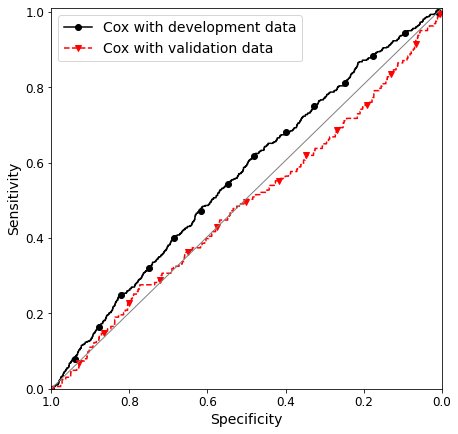

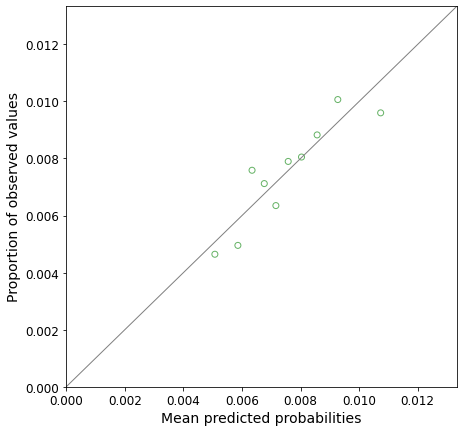

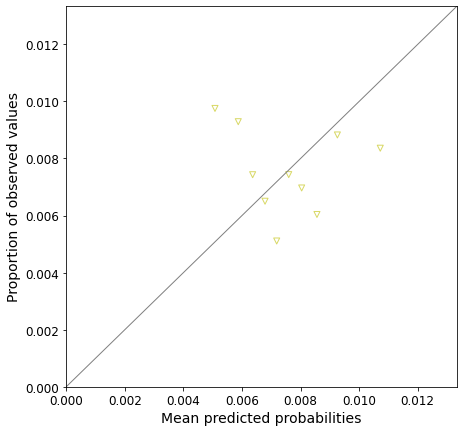

In [ ]:
#data prep
data, data_ot_externa_no_abs_incdt_enc = cox_data_prep(data_ot_externa_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

#make summary table
make_summary_table('ot_externa', 'no_abs_incdt', data_ot_externa_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('ot_externa', 'no_abs_incdt', data_ot_externa_no_abs_incdt)

try:
    #build cox model 
    cph_ot_externa_no_abs_incdt, data_ot_externa_no_abs_incdt_train, data_ot_externa_no_abs_incdt_test = cox_model_build('ot_externa', 'no_abs_incdt', data_ot_externa_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_ot_externa_no_abs_incdt, '../output/hospitalisation_prediction_ot_externa/', 'betas_cph_ot_externa_no_abs_incdt.csv', data_ot_externa_no_abs_incdt_enc, data_ot_externa_no_abs_incdt, 'sum_betas_cph_ot_externa_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_ot_externa_no_abs_incdt, 'event_ot_externa_admitted', data_ot_externa_no_abs_incdt_train, data_ot_externa_no_abs_incdt_test, '../output/hospitalisation_prediction_ot_externa', 'roc_cph_ot_externa_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_ot_externa_no_abs_incdt, data_ot_externa_no_abs_incdt_train, 'event_ot_externa_admitted', data_ot_externa_no_abs_incdt_test, '../output/hospitalisation_prediction_ot_externa/', 'calibration_cph_ot_externa_no_abs_incdt_train.jpg', 'calibration_cph_ot_externa_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_ot_externa_no_abs_incdt, 'ot_externa', 'no_abs_incdt', data_ot_externa_no_abs_incdt_train, data_ot_externa_no_abs_incdt_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident ot_externa with antibiotics

<lifelines.CoxPHFitter: fitted with 7249 total observations, 7189 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 7249
number of events observed = 60
   partial log-likelihood = -510.83
         time fit was run = 2022-11-17 10:38:52 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.25       1.28       0.39            -0.52             1.02                 0.60                 2.77
CCI_cat[T.medium]               -0.29       0.75       0.49            -1.25             0.66                 0.29                 1.94
CCI_cat[T.high]                 -0.39       0.68       0.60            -1.57             0.79                 0.21                 2.21
CCI_cat[T.very_high]             0.62       1.86       0.42            -0.21             1.45                 0.81                 4.25
age_cat[T.25_34]                 0.73       2.08       0.55            -0.35             1.81                 0.71                 6.09
age_cat[T.35_44]                 0.49       1.63       0.57            -0.63             1.61                 0.53                 4.99
age_cat[T.45_54]                 0.81       2.24       0.54            -0.26             1.87                 0.77                 6.46
age_cat[T.55_64]                 0.92       2.52       0.53            -0.12             1.97                 0.88                 7.17
age_cat[T.65_74]                -0.05       0.95       0.63            -1.29             1.19                 0.27                 3.30
age_cat[T.75_more]               0.53       1.70       0.56            -0.56             1.63                 0.57                 5.10
antibacterial_brit              -0.00       1.00       0.09            -0.18             0.18                 0.83                 1.20
bmi_cat[T.obese]                 0.07       1.07       0.54            -0.98             1.12                 0.37                 3.06
bmi_cat[T.overweight]            1.11       3.03       0.56             0.01             2.21                 1.01                 9.12
bmi_cat[T.underweight]           0.18       1.19       0.87            -1.53             1.88                 0.22                 6.55
bmi_cat[T.unknown]              -0.22       0.80       0.59            -1.39             0.94                 0.25                 2.56
ethnicity[T.unknown]             0.22       1.24       0.47            -0.70             1.13                 0.50                 3.09
ethnicity[T.white]               0.39       1.47       0.41            -0.42             1.20                 0.66                 3.31
flu_vaccine[T.yes]              -0.47       0.63       0.52            -1.48             0.55                 0.23                 1.73
imd[T.medium]                   -0.29       0.75       0.42            -1.10             0.53                 0.33                 1.70
imd[T.unaffluent]               -0.37       0.69       0.42            -1.18             0.45                 0.31                 1.57
imd[T.unknown]                  -0.47       0.63       0.76            -1.95             1.02                 0.14                 2.77
imd[T.very_affluent]            -0.06       0.94       0.39            -0.82             0.70                 0.44                 2.01
imd[T.very_unaffluent]          -0.32       0.73       0.40            -1.11             0.48                 0.33                 1.61
region[T.east_midlands]         -0.10       0.91       0.67            -1.42             1.22                 0.24                 3.39
region[T.london]                 0.45       1.57       0.52  

12776


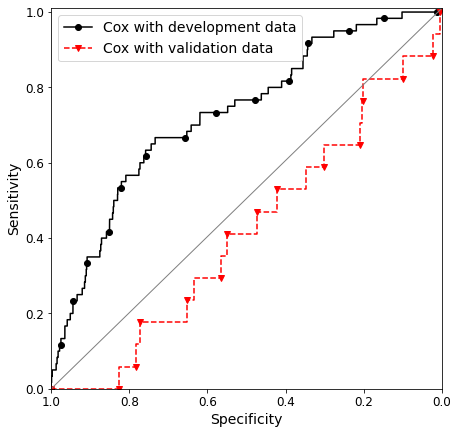

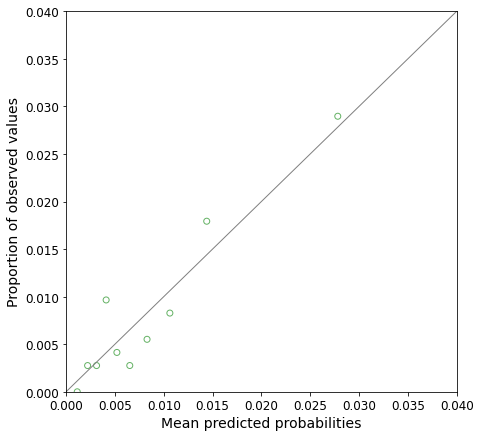

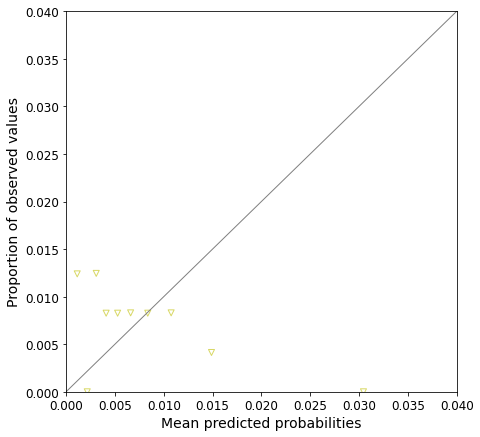

In [ ]:
#data prep
data, data_ot_externa_abs_incdt_enc = cox_data_prep(data_ot_externa_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

#make summary table
make_summary_table('ot_externa', 'abs_incdt', data_ot_externa_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('ot_externa', 'abs_incdt', data_ot_externa_abs_incdt)

try:
    #build cox model 
    cph_ot_externa_abs_incdt, data_ot_externa_abs_incdt_train, data_ot_externa_abs_incdt_test = cox_model_build('ot_externa', 'abs_incdt', data_ot_externa_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_ot_externa_abs_incdt, '../output/hospitalisation_prediction_ot_externa/', 'betas_cph_ot_externa_abs_incdt.csv', data_ot_externa_abs_incdt_enc, data_ot_externa_abs_incdt, 'sum_betas_cph_ot_externa_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_ot_externa_abs_incdt, 'event_ot_externa_admitted', data_ot_externa_abs_incdt_train, data_ot_externa_abs_incdt_test, '../output/hospitalisation_prediction_ot_externa', 'roc_cph_ot_externa_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_ot_externa_abs_incdt, data_ot_externa_abs_incdt_train, 'event_ot_externa_admitted', data_ot_externa_abs_incdt_test, '../output/hospitalisation_prediction_ot_externa/', 'calibration_cph_ot_externa_abs_incdt_train.jpg', 'calibration_cph_ot_externa_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_ot_externa_abs_incdt, 'ot_externa', 'abs_incdt', data_ot_externa_abs_incdt_train, data_ot_externa_abs_incdt_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent ot_externa with no antibiotics

<lifelines.CoxPHFitter: fitted with 7082 total observations, 7027 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 7082
number of events observed = 55
   partial log-likelihood = -463.90
         time fit was run = 2022-11-17 10:38:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.54       1.71       0.41            -0.26             1.34                 0.77                 3.81
CCI_cat[T.medium]               -0.09       0.91       0.50            -1.07             0.89                 0.34                 2.44
CCI_cat[T.high]                  0.97       2.63       0.48             0.03             1.90                 1.03                 6.71
CCI_cat[T.very_high]            -0.46       0.63       0.61            -1.66             0.74                 0.19                 2.10
age_cat[T.25_34]                 0.70       2.02       0.50            -0.28             1.69                 0.75                 5.40
age_cat[T.35_44]                 0.23       1.26       0.56            -0.86             1.33                 0.42                 3.76
age_cat[T.45_54]                 0.83       2.29       0.50            -0.14             1.80                 0.87                 6.05
age_cat[T.55_64]                 0.38       1.46       0.54            -0.68             1.44                 0.51                 4.24
age_cat[T.65_74]                -0.38       0.68       0.65            -1.65             0.88                 0.19                 2.42
age_cat[T.75_more]              -0.21       0.81       0.61            -1.40             0.98                 0.25                 2.66
antibacterial_brit              -0.05       0.95       0.10            -0.24             0.14                 0.79                 1.15
bmi_cat[T.obese]                -0.32       0.72       0.50            -1.30             0.65                 0.27                 1.92
bmi_cat[T.overweight]            0.59       1.80       0.55            -0.49             1.67                 0.61                 5.31
bmi_cat[T.underweight]           0.16       1.17       0.84            -1.49             1.81                 0.22                 6.09
bmi_cat[T.unknown]               0.13       1.14       0.52            -0.88             1.14                 0.42                 3.14
ethnicity[T.unknown]            -0.74       0.48       0.46            -1.65             0.17                 0.19                 1.18
ethnicity[T.white]              -0.23       0.80       0.36            -0.93             0.48                 0.39                 1.61
flu_vaccine[T.yes]               0.66       1.93       0.35            -0.03             1.35                 0.97                 3.86
imd[T.medium]                    0.56       1.76       0.42            -0.27             1.39                 0.77                 4.02
imd[T.unaffluent]               -0.25       0.78       0.50            -1.24             0.74                 0.29                 2.09
imd[T.unknown]                   0.29       1.33       0.67            -1.03             1.60                 0.36                 4.97
imd[T.very_affluent]            -0.23       0.79       0.51            -1.22             0.76                 0.29                 2.13
imd[T.very_unaffluent]           0.40       1.49       0.43            -0.44             1.24                 0.64                 3.44
region[T.east_midlands]          0.61       1.85       0.57            -0.51             1.74                 0.60                 5.68
region[T.london]                 0.34       1.40       0.53  

12775


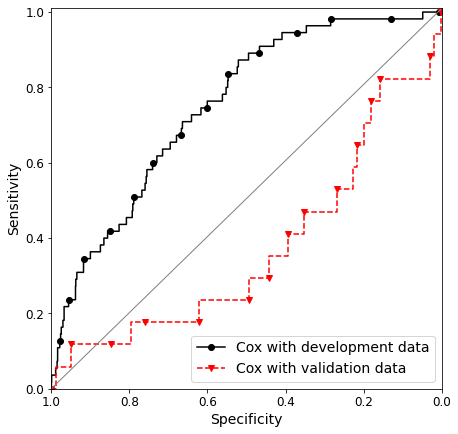

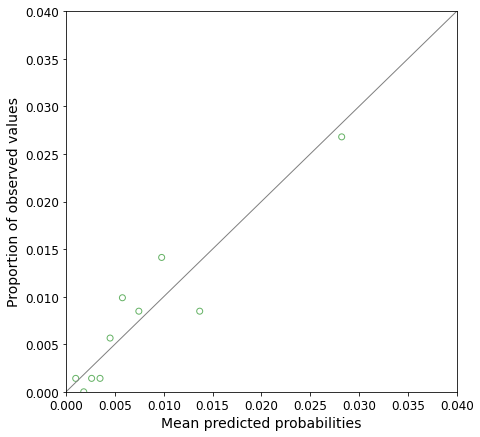

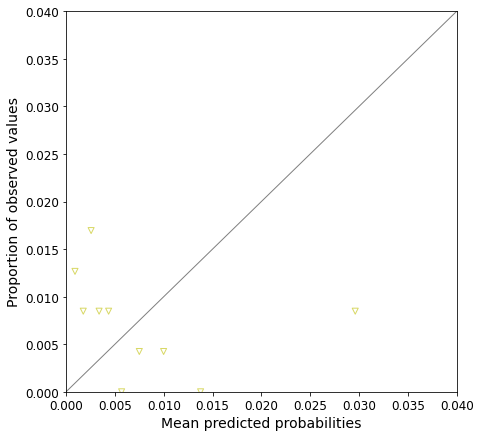

In [ ]:
#data prep
data, data_ot_externa_no_abs_prevl_enc = cox_data_prep(data_ot_externa_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

#make summary table
make_summary_table('ot_externa', 'no_abs_prevl', data_ot_externa_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('ot_externa', 'no_abs_prevl', data_ot_externa_no_abs_prevl)

try:
    #build cox model 
    cph_ot_externa_no_abs_prevl, data_ot_externa_no_abs_prevl_train, data_ot_externa_no_abs_prevl_test = cox_model_build('ot_externa', 'no_abs_prevl', data_ot_externa_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_ot_externa_no_abs_prevl, '../output/hospitalisation_prediction_ot_externa/', 'betas_cph_ot_externa_no_abs_prevl.csv', data_ot_externa_no_abs_prevl_enc, data_ot_externa_no_abs_prevl, 'sum_betas_cph_ot_externa_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_ot_externa_no_abs_prevl, 'event_ot_externa_admitted', data_ot_externa_no_abs_prevl_train, data_ot_externa_no_abs_prevl_test, '../output/hospitalisation_prediction_ot_externa', 'roc_cph_ot_externa_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_ot_externa_no_abs_prevl, data_ot_externa_no_abs_prevl_train, 'event_ot_externa_admitted', data_ot_externa_no_abs_prevl_test, '../output/hospitalisation_prediction_ot_externa/', 'calibration_cph_ot_externa_no_abs_prevl_train.jpg', 'calibration_cph_ot_externa_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_ot_externa_no_abs_prevl, 'ot_externa', 'no_abs_prevl', data_ot_externa_no_abs_prevl_train, data_ot_externa_no_abs_prevl_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent ot_externa with antibiotics

<lifelines.CoxPHFitter: fitted with 801 total observations, 791 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 801
number of events observed = 10
   partial log-likelihood = -50.08
         time fit was run = 2022-11-17 10:39:02 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  16.99   2.38e+07    4258.75         -8330.01          8363.98                 0.00                  inf
CCI_cat[T.medium]               18.58   1.17e+08    4258.75         -8328.42          8365.57                 0.00                  inf
CCI_cat[T.high]                 18.55   1.14e+08    4258.75         -8328.45          8365.54                 0.00                  inf
CCI_cat[T.very_high]            16.94   2.28e+07    4258.75         -8330.05          8363.94                 0.00                  inf
age_cat[T.25_34]                 0.14       1.15       1.52            -2.84             3.12                 0.06                22.70
age_cat[T.35_44]                 0.20       1.23       1.56            -2.86             3.27                 0.06                26.24
age_cat[T.45_54]                -0.27       0.76       1.57            -3.35             2.81                 0.03                16.61
age_cat[T.55_64]                -0.18       0.84       1.57            -3.25             2.89                 0.04                18.00
age_cat[T.65_74]                 0.62       1.86       1.37            -2.07             3.31                 0.13                27.47
age_cat[T.75_more]               1.32       3.74       1.26            -1.15             3.79                 0.32                44.10
antibacterial_brit               0.01       1.01       0.31            -0.60             0.61                 0.55                 1.85
bmi_cat[T.obese]                -0.95       0.39       1.03            -2.96             1.06                 0.05                 2.89
bmi_cat[T.overweight]            0.56       1.75       1.13            -1.66             2.78                 0.19                16.11
bmi_cat[T.underweight]         -17.75       0.00   10482.40        -20562.88         20527.39                 0.00                  inf
bmi_cat[T.unknown]              -1.92       0.15       1.35            -4.56             0.73                 0.01                 2.07
ethnicity[T.unknown]             0.59       1.81       1.26            -1.89             3.07                 0.15                21.55
ethnicity[T.white]               0.66       1.93       0.97            -1.23             2.55                 0.29                12.83
flu_vaccine[T.yes]               0.95       2.60       1.01            -1.03             2.94                 0.36                18.93
imd[T.medium]                   -0.45       0.64       1.17            -2.74             1.85                 0.06                 6.37
imd[T.unaffluent]                0.51       1.67       1.02            -1.49             2.52                 0.22                12.45
imd[T.unknown]                  -0.15       0.86       1.43            -2.96             2.66                 0.05                14.28
imd[T.very_affluent]            -1.25       0.29       1.35            -3.90             1.39                 0.02                 4.03
imd[T.very_unaffluent]          -0.54       0.58       1.31            -3.11             2.03                 0.04                 7.64
region[T.east_midlands]          0.35       1.42       1.45            -2.50             3.20                 0.08                24.47
region[T.london]                -1.53       0.22       1.53      

12920


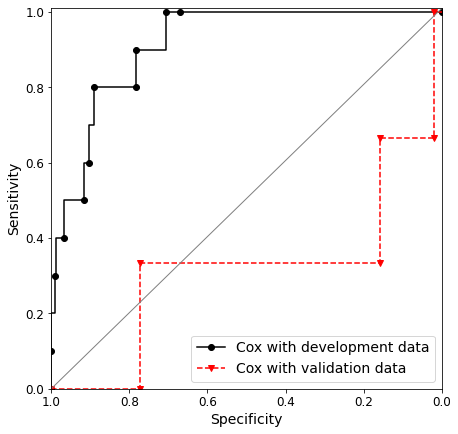

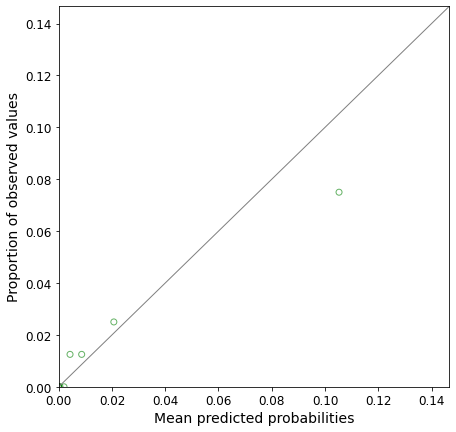

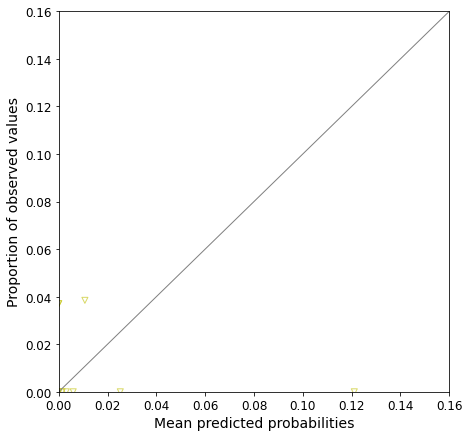

In [ ]:
#data prep
data, data_ot_externa_abs_prevl_enc = cox_data_prep(data_ot_externa_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

#make summary table
make_summary_table('ot_externa', 'abs_prevl', data_ot_externa_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('ot_externa', 'abs_prevl', data_ot_externa_abs_prevl)

try:
    #build cox model 
    cph_ot_externa_abs_prevl, data_ot_externa_abs_prevl_train, data_ot_externa_abs_prevl_test = cox_model_build('ot_externa', 'abs_prevl', data_ot_externa_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_ot_externa_abs_prevl, '../output/hospitalisation_prediction_ot_externa/', 'betas_cph_ot_externa_abs_prevl.csv', data_ot_externa_abs_prevl_enc, data_ot_externa_abs_prevl, 'sum_betas_cph_ot_externa_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_ot_externa_abs_prevl, 'event_ot_externa_admitted', data_ot_externa_abs_prevl_train, data_ot_externa_abs_prevl_test, '../output/hospitalisation_prediction_ot_externa', 'roc_cph_ot_externa_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_ot_externa_abs_prevl, data_ot_externa_abs_prevl_train, 'event_ot_externa_admitted', data_ot_externa_abs_prevl_test, '../output/hospitalisation_prediction_ot_externa/', 'calibration_cph_ot_externa_abs_prevl_train.jpg', 'calibration_cph_ot_externa_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_ot_externa_abs_prevl, 'ot_externa', 'abs_prevl', data_ot_externa_abs_prevl_train, data_ot_externa_abs_prevl_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident ot_externa

In [ ]:
#data prep
data, data_ot_externa_incdt_enc = cox_data_prep(data_ot_externa_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

#make summary tables from preped data
make_summary_table('ot_externa', 'incdt', data_ot_externa_incdt_enc)
make_summary_table_hosped('ot_externa', 'incdt', data_ot_externa_incdt)

try:
    cph_ot_externa_incdt, data_ot_externa_incdt_train, data_ot_externa_incdt_test = cox_model_abs_build('ot_externa', 'incdt', data_ot_externa_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_ot_externa_incdt, 'ot_externa', 'incdt', data_ot_externa_incdt_train, data_ot_externa_incdt_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 71834 total observations, 71308 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 71834
number of events observed = 526
   partial log-likelihood = -5868.38
         time fit was run = 2022-11-17 10:39:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.00       1.00       0.13            -0.25             0.24                 0.78                 1.28
CCI_cat[T.medium]               -0.04       0.96       0.14            -0.32             0.24                 0.73                 1.28
CCI_cat[T.high]                  0.07       1.08       0.17            -0.26             0.40                 0.77                 1.50
CCI_cat[T.very_high]             0.13       1.14       0.15            -0.16             0.41                 0.85                 1.51
age_cat[T.25_34]                 0.08       1.08       0.16            -0.23             0.39                 0.79                 1.48
age_cat[T.35_44]                 0.07       1.07       0.16            -0.25             0.38                 0.78                 1.46
age_cat[T.45_54]                -0.08       0.93       0.17            -0.40             0.25                 0.67                 1.28
age_cat[T.55_64]                -0.08       0.92       0.17            -0.40             0.25                 0.67                 1.28
age_cat[T.65_74]                 0.01       1.01       0.16            -0.31             0.33                 0.74                 1.39
age_cat[T.75_more]              -0.08       0.93       0.17            -0.40             0.25                 0.67                 1.28
antibacterial_brit              -0.02       0.98       0.03            -0.08             0.04                 0.92                 1.04
bmi_cat[T.obese]                -0.01       0.99       0.16            -0.33             0.31                 0.72                 1.36
bmi_cat[T.overweight]            0.22       1.24       0.19            -0.16             0.60                 0.85                 1.81
bmi_cat[T.underweight]          -0.11       0.90       0.29            -0.68             0.46                 0.50                 1.59
bmi_cat[T.unknown]              -0.12       0.89       0.18            -0.46             0.23                 0.63                 1.26
ethnicity[T.unknown]             0.17       1.19       0.15            -0.11             0.46                 0.89                 1.58
ethnicity[T.white]               0.08       1.08       0.13            -0.18             0.34                 0.84                 1.40
flu_vaccine[T.yes]              -0.08       0.92       0.15            -0.38             0.21                 0.68                 1.24
imd[T.medium]                    0.07       1.07       0.14            -0.20             0.34                 0.82                 1.41
imd[T.unaffluent]               -0.03       0.97       0.14            -0.30             0.25                 0.74                 1.29
imd[T.unknown]                  -0.17       0.84       0.24            -0.64             0.30                 0.52                 1.34
imd[T.very_affluent]            -0.07       0.93       0.14            -0.35             0.21                 0.70                 1.23
imd[T.very_unaffluent]           0.04       1.04       0.14            -0.23             0.31                 0.79                 1.37
ot_externa_ab_date               0.19       1.21       0.13            -0.07             0.46                 0.93                 1.58
region[T.east_midlands]          0.12       1.13       0

13053


### 5-6- hospital admission related to prevalent ot_externa

In [ ]:
#data prep
data, data_ot_externa_prevl_enc = cox_data_prep(data_ot_externa_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

#make summary tables from preped data
make_summary_table('ot_externa', 'prevl', data_ot_externa_prevl_enc)
make_summary_table_hosped('ot_externa', 'prevl', data_ot_externa_prevl)

try:
    cph_ot_externa_prevl, data_ot_externa_prevl_train, data_ot_externa_prevl_test = cox_model_abs_build('ot_externa', 'prevl', data_ot_externa_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_ot_externa_prevl, 'ot_externa', 'prevl', data_ot_externa_prevl_train, data_ot_externa_prevl_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7883 total observations, 7819 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 7883
number of events observed = 64
   partial log-likelihood = -556.11
         time fit was run = 2022-11-17 10:39:15 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.36       1.43       0.39            -0.41             1.13                 0.66                 3.08
CCI_cat[T.medium]                0.24       1.27       0.43            -0.62             1.09                 0.54                 2.97
CCI_cat[T.high]                  0.79       2.20       0.46            -0.12             1.69                 0.89                 5.43
CCI_cat[T.very_high]             0.01       1.01       0.49            -0.94             0.97                 0.39                 2.63
age_cat[T.25_34]                 0.51       1.67       0.49            -0.44             1.47                 0.65                 4.33
age_cat[T.35_44]                 0.06       1.06       0.54            -0.99             1.11                 0.37                 3.04
age_cat[T.45_54]                 0.74       2.09       0.46            -0.17             1.65                 0.84                 5.18
age_cat[T.55_64]                 0.20       1.22       0.52            -0.82             1.22                 0.44                 3.39
age_cat[T.65_74]                 0.29       1.34       0.51            -0.70             1.28                 0.50                 3.60
age_cat[T.75_more]               0.24       1.27       0.52            -0.78             1.25                 0.46                 3.50
antibacterial_brit              -0.09       0.91       0.09            -0.27             0.09                 0.76                 1.09
bmi_cat[T.obese]                -0.43       0.65       0.40            -1.21             0.35                 0.30                 1.42
bmi_cat[T.overweight]            0.14       1.15       0.47            -0.77             1.06                 0.46                 2.88
bmi_cat[T.underweight]          -0.38       0.68       0.79            -1.93             1.18                 0.14                 3.24
bmi_cat[T.unknown]              -0.54       0.58       0.45            -1.43             0.34                 0.24                 1.40
ethnicity[T.unknown]            -0.31       0.74       0.42            -1.13             0.52                 0.32                 1.68
ethnicity[T.white]              -0.03       0.97       0.35            -0.72             0.67                 0.49                 1.95
flu_vaccine[T.yes]               0.50       1.65       0.35            -0.17             1.18                 0.84                 3.26
imd[T.medium]                   -0.33       0.72       0.40            -1.11             0.45                 0.33                 1.57
imd[T.unaffluent]               -0.31       0.74       0.39            -1.07             0.45                 0.34                 1.57
imd[T.unknown]                  -0.35       0.70       0.63            -1.60             0.89                 0.20                 2.44
imd[T.very_affluent]            -0.80       0.45       0.46            -1.70             0.10                 0.18                 1.10
imd[T.very_unaffluent]          -0.00       1.00       0.36            -0.71             0.71                 0.49                 2.03
ot_externa_ab_date               0.57       1.76       0.35            -0.11             1.25                 0.89                 3.47
region[T.east_midlands]         -0.11       0.89       0.46  

13065


### 5-7- hospital admission related to incident ot_externa with prescribed antibiotics categories

In [ ]:
#data prep
data, data_ot_externa_incdt_abs_enc = cox_data_prep(data_ot_externa_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_abs, data_ot_externa_incdt_abs_train, data_ot_externa_incdt_abs_test = cox_model_ab_type_build('ot_externa', 'incdt_ab_type', data_ot_externa_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_ot_externa_incdt_abs, 'ot_externa', 'incdt_abs', data_ot_externa_incdt_abs_train, data_ot_externa_incdt_abs_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 71834 total observations, 71308 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 71834
number of events observed = 526
   partial log-likelihood = -5868.24
         time fit was run = 2022-11-17 10:39:18 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.00       1.00       0.13            -0.25             0.24                 0.78                 1.28
CCI_cat[T.medium]               -0.04       0.96       0.14            -0.32             0.24                 0.73                 1.28
CCI_cat[T.high]                  0.07       1.08       0.17            -0.26             0.40                 0.77                 1.50
CCI_cat[T.very_high]             0.13       1.14       0.15            -0.16             0.41                 0.85                 1.51
ab_type_cat[T.Doxycycline]       0.03       1.03       1.15            -2.23             2.30                 0.11                 9.94
ab_type_cat[T.no]                0.06       1.06       0.58            -1.08             1.20                 0.34                 3.30
ab_type_cat[T.other]             0.27       1.31       0.59            -0.89             1.43                 0.41                 4.18
age_cat[T.25_34]                 0.08       1.08       0.16            -0.23             0.39                 0.79                 1.48
age_cat[T.35_44]                 0.07       1.07       0.16            -0.25             0.38                 0.78                 1.46
age_cat[T.45_54]                -0.08       0.93       0.17            -0.40             0.25                 0.67                 1.28
age_cat[T.55_64]                -0.08       0.92       0.17            -0.40             0.25                 0.67                 1.28
age_cat[T.65_74]                 0.01       1.01       0.16            -0.31             0.33                 0.74                 1.39
age_cat[T.75_more]              -0.08       0.93       0.17            -0.40             0.25                 0.67                 1.28
antibacterial_brit              -0.02       0.98       0.03            -0.08             0.04                 0.92                 1.04
bmi_cat[T.obese]                -0.01       0.99       0.16            -0.33             0.31                 0.72                 1.36
bmi_cat[T.overweight]            0.22       1.25       0.19            -0.16             0.60                 0.85                 1.82
bmi_cat[T.underweight]          -0.11       0.90       0.29            -0.68             0.47                 0.51                 1.59
bmi_cat[T.unknown]              -0.11       0.89       0.18            -0.46             0.23                 0.63                 1.26
ethnicity[T.unknown]             0.17       1.19       0.15            -0.11             0.46                 0.89                 1.58
ethnicity[T.white]               0.08       1.08       0.13            -0.18             0.34                 0.84                 1.40
flu_vaccine[T.yes]              -0.08       0.92       0.15            -0.38             0.21                 0.68                 1.24
imd[T.medium]                    0.07       1.07       0.14            -0.20             0.34                 0.82                 1.41
imd[T.unaffluent]               -0.03       0.97       0.14            -0.30             0.25                 0.74                 1.29
imd[T.unknown]                  -0.18       0.84       0.24            -0.65             0.29                 0.52                 1.34
imd[T.very_affluent]            -0.07       0.93       0

13610


### 5-8- hospital admission related to prevalent ot_externa with prescribed antibiotics categories

In [ ]:
#data prep
data, data_ot_externa_prevl_abs_enc = cox_data_prep(data_ot_externa_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_abs, data_ot_externa_prevl_abs_train, data_ot_externa_prevl_abs_test = cox_model_ab_type_build('ot_externa', 'prevl_ab_type', data_ot_externa_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_ot_externa_prevl_abs, 'ot_externa', 'prevl_abs', data_ot_externa_prevl_abs_train, data_ot_externa_prevl_abs_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7883 total observations, 7819 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 7883
number of events observed = 64
   partial log-likelihood = -555.23
         time fit was run = 2022-11-17 10:39:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.35       1.42       0.39            -0.42             1.12                 0.66                 3.06
CCI_cat[T.medium]                0.23       1.26       0.44            -0.63             1.08                 0.53                 2.95
CCI_cat[T.high]                  0.78       2.18       0.46            -0.12             1.69                 0.88                 5.39
CCI_cat[T.very_high]            -0.01       0.99       0.49            -0.97             0.94                 0.38                 2.57
ab_type_cat[T.Doxycycline]       1.10       3.00       1.43            -1.71             3.91                 0.18                49.80
ab_type_cat[T.no]               -0.99       0.37       1.02            -2.99             1.00                 0.05                 2.72
ab_type_cat[T.other]            -0.56       0.57       1.07            -2.65             1.53                 0.07                 4.63
age_cat[T.25_34]                 0.51       1.67       0.49            -0.44             1.47                 0.65                 4.33
age_cat[T.35_44]                 0.05       1.05       0.54            -1.00             1.10                 0.37                 3.01
age_cat[T.45_54]                 0.72       2.05       0.46            -0.19             1.63                 0.83                 5.09
age_cat[T.55_64]                 0.20       1.22       0.52            -0.82             1.22                 0.44                 3.38
age_cat[T.65_74]                 0.27       1.31       0.51            -0.72             1.26                 0.49                 3.54
age_cat[T.75_more]               0.22       1.24       0.52            -0.80             1.24                 0.45                 3.44
antibacterial_brit              -0.09       0.91       0.09            -0.28             0.09                 0.76                 1.09
bmi_cat[T.obese]                -0.45       0.64       0.40            -1.23             0.34                 0.29                 1.40
bmi_cat[T.overweight]            0.12       1.13       0.47            -0.80             1.04                 0.45                 2.82
bmi_cat[T.underweight]          -0.38       0.68       0.79            -1.93             1.18                 0.14                 3.24
bmi_cat[T.unknown]              -0.56       0.57       0.45            -1.45             0.32                 0.23                 1.38
ethnicity[T.unknown]            -0.30       0.74       0.42            -1.13             0.53                 0.32                 1.70
ethnicity[T.white]              -0.03       0.97       0.35            -0.73             0.66                 0.48                 1.94
flu_vaccine[T.yes]               0.49       1.63       0.35            -0.19             1.17                 0.83                 3.21
imd[T.medium]                   -0.32       0.73       0.40            -1.10             0.46                 0.33                 1.59
imd[T.unaffluent]               -0.31       0.73       0.39            -1.07             0.45                 0.34                 1.57
imd[T.unknown]                  -0.36       0.70       0.63            -1.61             0.88                 0.20                 2.42
imd[T.very_affluent]            -0.80       0.45       0.46  

13627


### 5-9- stratified by sex
#### 5-9-1- incident males

In [ ]:
#data prep
data, data_ot_externa_incdt_males_enc = cox_data_prep(data_ot_externa_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_males, data_ot_externa_incdt_males_train, data_ot_externa_incdt_males_test = cox_model_strat_sex_build('ot_externa', 'incdt_males', data_ot_externa_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_ot_externa_incdt_males, 'ot_externa', 'incdt_males', data_ot_externa_incdt_males_train, data_ot_externa_incdt_males_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 35161 total observations, 34905 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 35161
number of events observed = 256
   partial log-likelihood = -2658.05
         time fit was run = 2022-11-17 10:39:25 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.14       1.15       0.18            -0.21             0.48                 0.81                 1.62
CCI_cat[T.medium]               -0.28       0.76       0.22            -0.71             0.15                 0.49                 1.16
CCI_cat[T.high]                  0.00       1.00       0.25            -0.49             0.49                 0.62                 1.63
CCI_cat[T.very_high]             0.10       1.11       0.21            -0.31             0.51                 0.73                 1.67
age_cat[T.25_34]                -0.15       0.86       0.24            -0.62             0.32                 0.54                 1.37
age_cat[T.35_44]                 0.04       1.04       0.23            -0.41             0.49                 0.67                 1.63
age_cat[T.45_54]                -0.37       0.69       0.25            -0.87             0.13                 0.42                 1.14
age_cat[T.55_64]                -0.05       0.95       0.23            -0.50             0.40                 0.60                 1.50
age_cat[T.65_74]                 0.04       1.04       0.23            -0.41             0.48                 0.67                 1.62
age_cat[T.75_more]               0.15       1.16       0.22            -0.29             0.58                 0.75                 1.79
antibacterial_brit               0.00       1.00       0.04            -0.08             0.09                 0.92                 1.09
bmi_cat[T.obese]                -0.16       0.85       0.22            -0.59             0.27                 0.56                 1.30
bmi_cat[T.overweight]           -0.15       0.86       0.27            -0.68             0.39                 0.50                 1.47
bmi_cat[T.underweight]          -0.24       0.79       0.41            -1.04             0.56                 0.36                 1.75
bmi_cat[T.unknown]              -0.27       0.76       0.24            -0.74             0.20                 0.48                 1.22
ethnicity[T.unknown]             0.21       1.23       0.21            -0.20             0.62                 0.82                 1.86
ethnicity[T.white]               0.06       1.06       0.19            -0.31             0.43                 0.73                 1.54
flu_vaccine[T.yes]               0.20       1.23       0.19            -0.18             0.58                 0.84                 1.79
imd[T.medium]                   -0.13       0.88       0.21            -0.54             0.29                 0.58                 1.33
imd[T.unaffluent]                0.07       1.07       0.20            -0.33             0.46                 0.72                 1.58
imd[T.unknown]                  -0.38       0.69       0.38            -1.13             0.37                 0.32                 1.45
imd[T.very_affluent]             0.02       1.02       0.20            -0.38             0.42                 0.68                 1.52
imd[T.very_unaffluent]           0.21       1.23       0.19            -0.17             0.59                 0.84                 1.80
ot_externa_ab_date              -0.33       0.72       0.24            -0.80             0.13                 0.45                 1.14
region[T.east_midlands]          0.39       1.47       0

12782


#### 5-9-2- incident females

In [ ]:
#data prep
data, data_ot_externa_incdt_females_enc = cox_data_prep(data_ot_externa_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_females, data_ot_externa_incdt_females_train, data_ot_externa_incdt_females_test = cox_model_strat_sex_build('ot_externa', 'incdt_females', data_ot_externa_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_ot_externa_incdt_females, 'ot_externa', 'incdt_females', data_ot_externa_incdt_females_train, data_ot_externa_incdt_females_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36672 total observations, 36395 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 36672
number of events observed = 277
   partial log-likelihood = -2891.24
         time fit was run = 2022-11-17 10:39:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.17       0.84       0.18            -0.52             0.18                 0.60                 1.19
CCI_cat[T.medium]               -0.01       0.99       0.19            -0.38             0.37                 0.68                 1.44
CCI_cat[T.high]                 -0.03       0.97       0.23            -0.49             0.43                 0.61                 1.53
CCI_cat[T.very_high]             0.20       1.22       0.19            -0.18             0.58                 0.84                 1.78
age_cat[T.25_34]                -0.00       1.00       0.21            -0.42             0.41                 0.66                 1.51
age_cat[T.35_44]                -0.11       0.90       0.22            -0.54             0.32                 0.58                 1.38
age_cat[T.45_54]                -0.11       0.90       0.22            -0.54             0.32                 0.58                 1.38
age_cat[T.55_64]                -0.06       0.94       0.22            -0.49             0.37                 0.61                 1.44
age_cat[T.65_74]                -0.12       0.89       0.22            -0.55             0.31                 0.58                 1.37
age_cat[T.75_more]              -0.34       0.71       0.23            -0.80             0.12                 0.45                 1.13
antibacterial_brit              -0.02       0.98       0.04            -0.11             0.06                 0.90                 1.06
bmi_cat[T.obese]                 0.15       1.16       0.24            -0.33             0.63                 0.72                 1.88
bmi_cat[T.overweight]            0.41       1.51       0.28            -0.13             0.96                 0.88                 2.61
bmi_cat[T.underweight]          -0.27       0.76       0.47            -1.19             0.65                 0.30                 1.91
bmi_cat[T.unknown]               0.15       1.16       0.26            -0.36             0.66                 0.70                 1.93
ethnicity[T.unknown]            -0.04       0.96       0.21            -0.45             0.37                 0.64                 1.44
ethnicity[T.white]               0.16       1.18       0.18            -0.19             0.51                 0.83                 1.67
flu_vaccine[T.yes]              -0.25       0.78       0.22            -0.69             0.18                 0.50                 1.20
imd[T.medium]                    0.15       1.16       0.18            -0.21             0.50                 0.81                 1.65
imd[T.unaffluent]               -0.02       0.98       0.19            -0.38             0.35                 0.68                 1.42
imd[T.unknown]                  -0.60       0.55       0.38            -1.35             0.14                 0.26                 1.15
imd[T.very_affluent]            -0.21       0.81       0.20            -0.60             0.18                 0.55                 1.20
imd[T.very_unaffluent]          -0.24       0.78       0.20            -0.64             0.15                 0.53                 1.16
ot_externa_ab_date               0.34       1.40       0.18            -0.01             0.69                 0.99                 1.98
region[T.east_midlands]          0.19       1.21       0

12793


#### 5-9-3- prevalent males

In [ ]:
#data prep
data, data_ot_externa_prevl_males_enc = cox_data_prep(data_ot_externa_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_males, data_ot_externa_prevl_males_train, data_ot_externa_prevl_males_test = cox_model_strat_sex_build('ot_externa', 'prevl_males', data_ot_externa_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cph_output(cph_ot_externa_prevl_males, 'ot_externa', 'prevl_males', data_ot_externa_prevl_males_train, data_ot_externa_prevl_males_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3909 total observations, 3876 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 3909
number of events observed = 33
   partial log-likelihood = -247.85
         time fit was run = 2022-11-17 10:39:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.93       2.53       0.77            -0.59             2.44                 0.56                11.48
CCI_cat[T.medium]                1.11       3.04       0.80            -0.45             2.67                 0.64                14.46
CCI_cat[T.high]                  2.09       8.09       0.78             0.56             3.62                 1.75                37.39
CCI_cat[T.very_high]             0.12       1.12       1.00            -1.85             2.08                 0.16                 8.02
age_cat[T.25_34]                 0.92       2.51       0.69            -0.42             2.27                 0.65                 9.64
age_cat[T.35_44]                 0.43       1.54       0.77            -1.08             1.94                 0.34                 6.99
age_cat[T.45_54]                 1.00       2.71       0.68            -0.34             2.34                 0.71                10.35
age_cat[T.55_64]                -0.00       1.00       0.82            -1.62             1.61                 0.20                 4.98
age_cat[T.65_74]                 0.32       1.38       0.77            -1.19             1.83                 0.31                 6.23
age_cat[T.75_more]               0.02       1.02       0.82            -1.59             1.63                 0.20                 5.13
antibacterial_brit              -0.07       0.93       0.13            -0.32             0.18                 0.72                 1.20
bmi_cat[T.obese]                -0.42       0.66       0.65            -1.70             0.86                 0.18                 2.35
bmi_cat[T.overweight]            0.52       1.68       0.72            -0.90             1.94                 0.41                 6.94
bmi_cat[T.underweight]         -16.07       0.00    2731.80         -5370.29          5338.16                 0.00                  inf
bmi_cat[T.unknown]               0.25       1.29       0.66            -1.05             1.56                 0.35                 4.74
ethnicity[T.unknown]            -0.69       0.50       0.56            -1.80             0.41                 0.17                 1.50
ethnicity[T.white]              -0.34       0.71       0.45            -1.22             0.53                 0.30                 1.70
flu_vaccine[T.yes]               0.86       2.35       0.43             0.01             1.70                 1.01                 5.49
imd[T.medium]                    0.62       1.85       0.55            -0.46             1.69                 0.63                 5.44
imd[T.unaffluent]                0.17       1.19       0.61            -1.02             1.36                 0.36                 3.91
imd[T.unknown]                   0.42       1.53       0.85            -1.24             2.09                 0.29                 8.08
imd[T.very_affluent]            -0.56       0.57       0.73            -2.00             0.88                 0.14                 2.40
imd[T.very_unaffluent]           0.19       1.21       0.61            -1.01             1.38                 0.37                 3.98
ot_externa_ab_date               0.42       1.52       0.49            -0.55             1.39                 0.58                 4.01
region[T.east_midlands]          1.00       2.71       0.70  

12792


#### 5-9-4- prevalent females

In [ ]:
try:
    #data prep
    data, data_ot_externa_prevl_females_enc = cox_data_prep(data_ot_externa_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

    #cox model
    cph_ot_externa_prevl_females, data_ot_externa_prevl_females_train, data_ot_externa_prevl_females_test = cox_model_strat_sex_build('ot_externa', 'prevl_females', data_ot_externa_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_ot_externa_prevl_females, 'ot_externa', 'prevl_females', data_ot_externa_prevl_females_train, data_ot_externa_prevl_females_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3973 total observations, 3938 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 3973
number of events observed = 35
   partial log-likelihood = -275.91
         time fit was run = 2022-11-17 10:39:32 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.29       1.33       0.49            -0.67             1.24                 0.51                 3.45
CCI_cat[T.medium]               -0.19       0.82       0.58            -1.33             0.94                 0.26                 2.57
CCI_cat[T.high]                  0.17       1.18       0.65            -1.11             1.44                 0.33                 4.23
CCI_cat[T.very_high]            -0.36       0.70       0.65            -1.64             0.91                 0.19                 2.49
age_cat[T.25_34]                 0.19       1.20       0.61            -1.01             1.38                 0.36                 3.97
age_cat[T.35_44]                -0.04       0.96       0.64            -1.28             1.21                 0.28                 3.35
age_cat[T.45_54]                -0.00       1.00       0.64            -1.25             1.25                 0.29                 3.48
age_cat[T.55_64]                 0.23       1.26       0.61            -0.96             1.42                 0.38                 4.16
age_cat[T.65_74]                 0.00       1.00       0.64            -1.24             1.25                 0.29                 3.49
age_cat[T.75_more]              -0.57       0.57       0.74            -2.01             0.88                 0.13                 2.41
antibacterial_brit              -0.12       0.89       0.13            -0.37             0.13                 0.69                 1.14
bmi_cat[T.obese]                -0.28       0.76       0.57            -1.39             0.83                 0.25                 2.30
bmi_cat[T.overweight]            0.32       1.38       0.65            -0.96             1.60                 0.38                 4.97
bmi_cat[T.underweight]           0.44       1.55       0.88            -1.28             2.16                 0.28                 8.64
bmi_cat[T.unknown]              -0.46       0.63       0.63            -1.70             0.78                 0.18                 2.18
ethnicity[T.unknown]            -0.52       0.59       0.61            -1.72             0.67                 0.18                 1.96
ethnicity[T.white]              -0.00       1.00       0.50            -0.98             0.97                 0.38                 2.64
flu_vaccine[T.yes]               0.12       1.13       0.54            -0.93             1.18                 0.40                 3.25
imd[T.medium]                   -0.54       0.58       0.52            -1.56             0.48                 0.21                 1.62
imd[T.unaffluent]               -0.45       0.64       0.50            -1.43             0.52                 0.24                 1.69
imd[T.unknown]                  -1.17       0.31       1.05            -3.23             0.90                 0.04                 2.46
imd[T.very_affluent]            -1.29       0.27       0.66            -2.59             0.01                 0.08                 1.01
imd[T.very_unaffluent]          -0.27       0.76       0.48            -1.21             0.67                 0.30                 1.94
ot_externa_ab_date               0.68       1.96       0.46            -0.22             1.57                 0.80                 4.79
region[T.east_midlands]         -0.90       0.40       0.84  

12797


### 5-10- stratified by age category
#### 5-10-1- incident

In [ ]:
#data prep
data, data_ot_externa_incdt_15_24_enc = cox_data_prep(data_ot_externa_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_15_24, data_ot_externa_incdt_15_24_train, data_ot_externa_incdt_15_24_test = cox_model_strat_age_build('ot_externa', 'incdt_15_24', data_ot_externa_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_ot_externa_incdt_15_24, 'ot_externa', 'incdt_15_24', data_ot_externa_incdt_15_24_train, data_ot_externa_incdt_15_24_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10290 total observations, 10213 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 10290
number of events observed = 77
   partial log-likelihood = -698.16
         time fit was run = 2022-11-17 10:39:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.21       1.24       0.34            -0.46             0.89                 0.63                 2.43
CCI_cat[T.medium]                0.10       1.11       0.39            -0.66             0.86                 0.52                 2.37
CCI_cat[T.high]                 -0.06       0.94       0.50            -1.04             0.92                 0.35                 2.51
CCI_cat[T.very_high]             0.33       1.39       0.39            -0.43             1.09                 0.65                 2.98
antibacterial_brit              -0.09       0.91       0.08            -0.25             0.07                 0.78                 1.08
bmi_cat[T.obese]                -0.39       0.67       0.37            -1.12             0.33                 0.33                 1.39
bmi_cat[T.overweight]           -0.76       0.47       0.53            -1.79             0.28                 0.17                 1.32
bmi_cat[T.underweight]          -0.19       0.83       0.67            -1.50             1.12                 0.22                 3.07
bmi_cat[T.unknown]              -0.34       0.71       0.40            -1.13             0.45                 0.32                 1.57
ethnicity[T.unknown]             0.40       1.50       0.45            -0.47             1.28                 0.62                 3.59
ethnicity[T.white]               0.59       1.80       0.40            -0.20             1.38                 0.82                 3.98
flu_vaccine[T.yes]               0.35       1.42       0.36            -0.35             1.05                 0.71                 2.86
imd[T.medium]                   -0.49       0.61       0.37            -1.22             0.23                 0.30                 1.26
imd[T.unaffluent]               -0.51       0.60       0.38            -1.25             0.24                 0.29                 1.27
imd[T.unknown]                   0.53       1.70       0.42            -0.30             1.36                 0.74                 3.89
imd[T.very_affluent]            -0.46       0.63       0.37            -1.18             0.27                 0.31                 1.31
imd[T.very_unaffluent]          -0.23       0.80       0.35            -0.91             0.45                 0.40                 1.57
ot_externa_ab_date              -0.71       0.49       0.51            -1.72             0.29                 0.18                 1.34
region[T.east_midlands]         -1.05       0.35       0.59            -2.22             0.11                 0.11                 1.11
region[T.london]                -0.42       0.66       0.41            -1.22             0.38                 0.30                 1.47
region[T.north_east]            -0.36       0.70       0.47            -1.29             0.57                 0.28                 1.77
region[T.north_west]            -0.26       0.77       0.46            -1.16             0.65                 0.31                 1.91
region[T.south_east]            -0.02       0.98       0.44            -0.88             0.84                 0.41                 2.31
region[T.south_west]            -0.34       0.71       0.48            -1.28             0.59                 0.28                 1.80
region[T.west_midlands]         -0.77       0.46       0.5

11426


In [ ]:
#data prep
data, data_ot_externa_incdt_25_34_enc = cox_data_prep(data_ot_externa_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_25_34, data_ot_externa_incdt_25_34_train, data_ot_externa_incdt_25_34_test = cox_model_strat_age_build('ot_externa', 'incdt_25_34', data_ot_externa_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_ot_externa_incdt_25_34, 'ot_externa', 'incdt_25_34', data_ot_externa_incdt_25_34_train, data_ot_externa_incdt_25_34_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10340 total observations, 10262 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 10340
number of events observed = 78
   partial log-likelihood = -702.39
         time fit was run = 2022-11-17 10:39:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.54       0.58       0.32            -1.17             0.09                 0.31                 1.09
CCI_cat[T.medium]               -0.19       0.83       0.33            -0.84             0.47                 0.43                 1.60
CCI_cat[T.high]                 -0.23       0.79       0.42            -1.06             0.60                 0.35                 1.81
CCI_cat[T.very_high]            -0.14       0.87       0.35            -0.83             0.56                 0.44                 1.75
antibacterial_brit              -0.04       0.96       0.08            -0.20             0.12                 0.82                 1.12
bmi_cat[T.obese]                 0.13       1.14       0.44            -0.73             0.98                 0.48                 2.67
bmi_cat[T.overweight]           -0.47       0.62       0.61            -1.66             0.72                 0.19                 2.05
bmi_cat[T.underweight]          -1.06       0.35       1.08            -3.17             1.06                 0.04                 2.90
bmi_cat[T.unknown]               0.05       1.05       0.47            -0.86             0.97                 0.42                 2.63
ethnicity[T.unknown]            -0.25       0.78       0.35            -0.95             0.44                 0.39                 1.55
ethnicity[T.white]              -0.23       0.80       0.31            -0.83             0.37                 0.44                 1.45
flu_vaccine[T.yes]              -0.99       0.37       0.59            -2.14             0.17                 0.12                 1.18
imd[T.medium]                    0.62       1.85       0.39            -0.15             1.38                 0.86                 3.99
imd[T.unaffluent]                0.54       1.72       0.40            -0.23             1.32                 0.79                 3.74
imd[T.unknown]                   0.18       1.19       0.66            -1.11             1.47                 0.33                 4.35
imd[T.very_affluent]             0.59       1.80       0.40            -0.19             1.36                 0.83                 3.91
imd[T.very_unaffluent]           0.03       1.03       0.45            -0.85             0.91                 0.43                 2.48
ot_externa_ab_date               0.39       1.48       0.33            -0.25             1.03                 0.78                 2.80
region[T.east_midlands]          0.62       1.86       0.45            -0.26             1.50                 0.77                 4.49
region[T.london]                -0.04       0.96       0.43            -0.89             0.81                 0.41                 2.25
region[T.north_east]            -0.70       0.50       0.61            -1.90             0.50                 0.15                 1.65
region[T.north_west]            -0.25       0.78       0.54            -1.31             0.81                 0.27                 2.25
region[T.south_east]             0.17       1.19       0.48            -0.76             1.11                 0.47                 3.02
region[T.south_west]             0.04       1.04       0.50            -0.94             1.02                 0.39                 2.77
region[T.west_midlands]          0.13       1.13       0.4

11418


In [ ]:
#data prep
data, data_ot_externa_incdt_35_44_enc = cox_data_prep(data_ot_externa_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_35_44, data_ot_externa_incdt_35_44_train, data_ot_externa_incdt_35_44_test = cox_model_strat_age_build('ot_externa', 'incdt_35_44', data_ot_externa_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_ot_externa_incdt_35_44, 'ot_externa', 'incdt_35_44', data_ot_externa_incdt_35_44_train, data_ot_externa_incdt_35_44_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10177 total observations, 10091 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 10177
number of events observed = 86
   partial log-likelihood = -778.71
         time fit was run = 2022-11-17 10:39:36 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.17       0.84       0.29            -0.73             0.39                 0.48                 1.48
CCI_cat[T.medium]               -0.51       0.60       0.37            -1.23             0.20                 0.29                 1.23
CCI_cat[T.high]                  0.13       1.13       0.38            -0.61             0.86                 0.54                 2.37
CCI_cat[T.very_high]            -0.41       0.67       0.38            -1.14             0.33                 0.32                 1.39
antibacterial_brit               0.00       1.00       0.08            -0.15             0.15                 0.86                 1.17
bmi_cat[T.obese]                -0.36       0.70       0.35            -1.04             0.33                 0.35                 1.39
bmi_cat[T.overweight]           -0.24       0.79       0.44            -1.10             0.62                 0.33                 1.86
bmi_cat[T.underweight]          -1.47       0.23       1.05            -3.53             0.59                 0.03                 1.80
bmi_cat[T.unknown]              -0.65       0.52       0.40            -1.43             0.14                 0.24                 1.15
ethnicity[T.unknown]             0.24       1.27       0.35            -0.45             0.93                 0.64                 2.54
ethnicity[T.white]               0.01       1.01       0.32            -0.63             0.64                 0.54                 1.90
flu_vaccine[T.yes]               0.16       1.17       0.34            -0.50             0.82                 0.60                 2.27
imd[T.medium]                   -0.55       0.58       0.40            -1.32             0.23                 0.27                 1.25
imd[T.unaffluent]                0.04       1.04       0.33            -0.61             0.70                 0.54                 2.01
imd[T.unknown]                  -1.41       0.24       1.03            -3.42             0.61                 0.03                 1.84
imd[T.very_affluent]             0.02       1.02       0.34            -0.65             0.68                 0.52                 1.98
imd[T.very_unaffluent]           0.25       1.28       0.32            -0.38             0.87                 0.69                 2.39
ot_externa_ab_date              -0.37       0.69       0.42            -1.20             0.46                 0.30                 1.58
region[T.east_midlands]          0.26       1.29       0.44            -0.61             1.12                 0.54                 3.08
region[T.london]                -0.07       0.94       0.41            -0.88             0.74                 0.42                 2.10
region[T.north_east]            -0.30       0.74       0.51            -1.29             0.69                 0.27                 1.99
region[T.north_west]            -0.29       0.74       0.51            -1.29             0.70                 0.28                 2.01
region[T.south_east]            -0.12       0.89       0.49            -1.07             0.84                 0.34                 2.31
region[T.south_west]            -0.53       0.59       0.56            -1.63             0.56                 0.20                 1.75
region[T.west_midlands]          0.11       1.12       0.4

11418


In [ ]:
#data prep
data, data_ot_externa_incdt_45_54_enc = cox_data_prep(data_ot_externa_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_45_54, data_ot_externa_incdt_45_54_train, data_ot_externa_incdt_45_54_test = cox_model_strat_age_build('ot_externa', 'incdt_45_54', data_ot_externa_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_ot_externa_incdt_45_54, 'ot_externa', 'incdt_45_54', data_ot_externa_incdt_45_54_train, data_ot_externa_incdt_45_54_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10268 total observations, 10199 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 10268
number of events observed = 69
   partial log-likelihood = -608.98
         time fit was run = 2022-11-17 10:39:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.34       0.71       0.37            -1.06             0.37                 0.35                 1.45
CCI_cat[T.medium]                0.24       1.27       0.37            -0.48             0.96                 0.62                 2.60
CCI_cat[T.high]                 -0.37       0.69       0.53            -1.41             0.66                 0.25                 1.94
CCI_cat[T.very_high]             0.21       1.24       0.38            -0.53             0.96                 0.59                 2.61
antibacterial_brit              -0.04       0.96       0.09            -0.21             0.13                 0.81                 1.14
bmi_cat[T.obese]                 0.13       1.13       0.48            -0.81             1.06                 0.44                 2.90
bmi_cat[T.overweight]            0.21       1.24       0.57            -0.91             1.33                 0.40                 3.80
bmi_cat[T.underweight]           0.40       1.50       0.73            -1.03             1.84                 0.36                 6.28
bmi_cat[T.unknown]               0.12       1.13       0.51            -0.88             1.12                 0.42                 3.07
ethnicity[T.unknown]            -0.27       0.77       0.38            -1.02             0.49                 0.36                 1.63
ethnicity[T.white]              -0.17       0.84       0.33            -0.82             0.48                 0.44                 1.61
flu_vaccine[T.yes]              -0.19       0.82       0.43            -1.03             0.65                 0.36                 1.91
imd[T.medium]                    0.68       1.97       0.34             0.01             1.35                 1.01                 3.85
imd[T.unaffluent]               -0.40       0.67       0.44            -1.26             0.45                 0.28                 1.57
imd[T.unknown]                 -16.98       0.00    2576.12         -5066.09          5032.12                 0.00                  inf
imd[T.very_affluent]            -0.49       0.62       0.45            -1.37             0.40                 0.25                 1.49
imd[T.very_unaffluent]           0.07       1.07       0.39            -0.70             0.84                 0.49                 2.32
ot_externa_ab_date               0.43       1.54       0.34            -0.24             1.10                 0.78                 3.02
region[T.east_midlands]         -0.27       0.76       0.91            -2.06             1.52                 0.13                 4.56
region[T.london]                 1.23       3.43       0.62             0.01             2.45                 1.01                11.61
region[T.north_east]             1.46       4.31       0.65             0.19             2.73                 1.21                15.29
region[T.north_west]             0.42       1.53       0.76            -1.08             1.92                 0.34                 6.84
region[T.south_east]             0.98       2.66       0.69            -0.38             2.33                 0.69                10.31
region[T.south_west]             1.34       3.81       0.65             0.06             2.62                 1.06                13.70
region[T.west_midlands]          0.47       1.60       0.7

11427


In [ ]:
#data prep
data, data_ot_externa_incdt_55_64_enc = cox_data_prep(data_ot_externa_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_55_64, data_ot_externa_incdt_55_64_train, data_ot_externa_incdt_55_64_test = cox_model_strat_age_build('ot_externa', 'incdt_55_64', data_ot_externa_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_ot_externa_incdt_55_64, 'ot_externa', 'incdt_55_64', data_ot_externa_incdt_55_64_train, data_ot_externa_incdt_55_64_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10223 total observations, 10147 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 10223
number of events observed = 76
   partial log-likelihood = -681.08
         time fit was run = 2022-11-17 10:39:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.37       0.69       0.32            -0.98             0.25                 0.37                 1.29
CCI_cat[T.medium]               -0.48       0.62       0.37            -1.21             0.25                 0.30                 1.29
CCI_cat[T.high]                 -0.44       0.64       0.45            -1.32             0.43                 0.27                 1.54
CCI_cat[T.very_high]            -0.03       0.97       0.34            -0.70             0.65                 0.50                 1.91
antibacterial_brit               0.01       1.01       0.08            -0.15             0.17                 0.86                 1.18
bmi_cat[T.obese]                 1.29       3.63       0.72            -0.13             2.71                 0.88                14.98
bmi_cat[T.overweight]            1.75       5.74       0.75             0.28             3.22                 1.32                25.00
bmi_cat[T.underweight]           0.08       1.08       1.23            -2.33             2.48                 0.10                11.97
bmi_cat[T.unknown]               0.80       2.22       0.76            -0.69             2.29                 0.50                 9.87
ethnicity[T.unknown]             0.18       1.20       0.39            -0.57             0.94                 0.57                 2.56
ethnicity[T.white]               0.10       1.11       0.35            -0.58             0.79                 0.56                 2.21
flu_vaccine[T.yes]              -0.01       0.99       0.37            -0.74             0.72                 0.47                 2.06
imd[T.medium]                   -1.28       0.28       0.57            -2.39            -0.17                 0.09                 0.85
imd[T.unaffluent]                0.17       1.18       0.37            -0.55             0.89                 0.58                 2.43
imd[T.unknown]                   0.35       1.42       0.52            -0.67             1.37                 0.51                 3.95
imd[T.very_affluent]             0.08       1.09       0.37            -0.64             0.80                 0.53                 2.24
imd[T.very_unaffluent]           0.41       1.51       0.35            -0.27             1.09                 0.76                 2.97
ot_externa_ab_date               0.17       1.18       0.36            -0.53             0.86                 0.59                 2.37
region[T.east_midlands]          0.45       1.56       0.57            -0.67             1.57                 0.51                 4.79
region[T.london]                 0.45       1.57       0.51            -0.56             1.45                 0.57                 4.28
region[T.north_east]             0.37       1.45       0.59            -0.78             1.52                 0.46                 4.58
region[T.north_west]             0.73       2.07       0.54            -0.33             1.79                 0.72                 5.98
region[T.south_east]             0.26       1.30       0.59            -0.89             1.41                 0.41                 4.10
region[T.south_west]             0.23       1.26       0.59            -0.91             1.38                 0.40                 3.99
region[T.west_midlands]          0.40       1.50       0.5

11403


In [ ]:
#data prep
data, data_ot_externa_incdt_65_74_enc = cox_data_prep(data_ot_externa_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_65_74, data_ot_externa_incdt_65_74_train, data_ot_externa_incdt_65_74_test = cox_model_strat_age_build('ot_externa', 'incdt_65_74', data_ot_externa_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_ot_externa_incdt_65_74, 'ot_externa', 'incdt_65_74', data_ot_externa_incdt_65_74_train, data_ot_externa_incdt_65_74_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10308 total observations, 10223 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 10308
number of events observed = 85
   partial log-likelihood = -772.30
         time fit was run = 2022-11-17 10:39:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.11       0.90       0.32            -0.73             0.52                 0.48                 1.67
CCI_cat[T.medium]                0.36       1.43       0.32            -0.27             0.99                 0.76                 2.70
CCI_cat[T.high]                 -0.19       0.83       0.45            -1.08             0.70                 0.34                 2.02
CCI_cat[T.very_high]            -0.15       0.86       0.38            -0.91             0.60                 0.40                 1.81
antibacterial_brit               0.03       1.03       0.08            -0.12             0.18                 0.89                 1.19
bmi_cat[T.obese]                 0.21       1.24       0.48            -0.72             1.14                 0.49                 3.14
bmi_cat[T.overweight]            0.55       1.74       0.53            -0.49             1.60                 0.61                 4.94
bmi_cat[T.underweight]           0.49       1.63       0.73            -0.95             1.92                 0.39                 6.83
bmi_cat[T.unknown]               0.43       1.54       0.49            -0.53             1.40                 0.59                 4.04
ethnicity[T.unknown]             0.23       1.26       0.37            -0.49             0.96                 0.61                 2.61
ethnicity[T.white]               0.14       1.15       0.33            -0.52             0.79                 0.60                 2.20
flu_vaccine[T.yes]              -0.23       0.80       0.40            -1.00             0.55                 0.37                 1.73
imd[T.medium]                    0.25       1.29       0.35            -0.43             0.93                 0.65                 2.54
imd[T.unaffluent]                0.37       1.44       0.34            -0.29             1.03                 0.75                 2.79
imd[T.unknown]                   0.04       1.05       0.56            -1.06             1.15                 0.35                 3.16
imd[T.very_affluent]            -0.21       0.81       0.39            -0.97             0.55                 0.38                 1.73
imd[T.very_unaffluent]          -0.15       0.86       0.38            -0.90             0.59                 0.41                 1.81
ot_externa_ab_date              -0.80       0.45       0.51            -1.81             0.20                 0.16                 1.22
region[T.east_midlands]          0.55       1.74       0.56            -0.54             1.65                 0.58                 5.21
region[T.london]                 0.60       1.81       0.50            -0.39             1.58                 0.68                 4.87
region[T.north_east]             0.01       1.01       0.63            -1.23             1.25                 0.29                 3.50
region[T.north_west]             0.74       2.10       0.54            -0.32             1.80                 0.73                 6.04
region[T.south_east]             0.89       2.44       0.53            -0.15             1.94                 0.86                 6.94
region[T.south_west]             0.13       1.14       0.61            -1.06             1.32                 0.35                 3.73
region[T.west_midlands]          0.50       1.64       0.5

11408


In [ ]:
#data prep
data, data_ot_externa_incdt_75_more_enc = cox_data_prep(data_ot_externa_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_75_more, data_ot_externa_incdt_75_more_train, data_ot_externa_incdt_75_more_test = cox_model_strat_age_build('ot_externa', 'incdt_75_more', data_ot_externa_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_ot_externa_incdt_75_more, 'ot_externa', 'incdt_75_more', data_ot_externa_incdt_75_more_train, data_ot_externa_incdt_75_more_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10226 total observations, 10147 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 10226
number of events observed = 79
   partial log-likelihood = -712.30
         time fit was run = 2022-11-17 10:39:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.35       1.42       0.34            -0.32             1.01                 0.73                 2.76
CCI_cat[T.medium]                0.12       1.13       0.39            -0.64             0.88                 0.53                 2.41
CCI_cat[T.high]                 -0.23       0.79       0.53            -1.28             0.82                 0.28                 2.26
CCI_cat[T.very_high]             0.35       1.42       0.39            -0.41             1.11                 0.67                 3.05
antibacterial_brit               0.13       1.14       0.08            -0.02             0.28                 0.98                 1.32
bmi_cat[T.obese]                -0.01       0.99       0.41            -0.81             0.79                 0.45                 2.20
bmi_cat[T.overweight]           -0.03       0.97       0.51            -1.02             0.96                 0.36                 2.62
bmi_cat[T.underweight]          -0.40       0.67       0.80            -1.98             1.17                 0.14                 3.23
bmi_cat[T.unknown]              -0.34       0.71       0.45            -1.23             0.55                 0.29                 1.73
ethnicity[T.unknown]             0.28       1.33       0.36            -0.42             0.99                 0.65                 2.69
ethnicity[T.white]              -0.10       0.91       0.34            -0.76             0.57                 0.47                 1.77
flu_vaccine[T.yes]               0.22       1.25       0.36            -0.47             0.92                 0.62                 2.51
imd[T.medium]                    0.18       1.20       0.37            -0.54             0.90                 0.58                 2.46
imd[T.unaffluent]                0.22       1.25       0.37            -0.50             0.94                 0.61                 2.56
imd[T.unknown]                  -0.56       0.57       0.76            -2.04             0.92                 0.13                 2.52
imd[T.very_affluent]             0.22       1.25       0.36            -0.49             0.93                 0.61                 2.54
imd[T.very_unaffluent]           0.01       1.01       0.38            -0.73             0.75                 0.48                 2.13
ot_externa_ab_date               0.32       1.38       0.33            -0.32             0.96                 0.73                 2.61
region[T.east_midlands]         -0.08       0.92       0.42            -0.90             0.74                 0.41                 2.10
region[T.london]                -0.50       0.61       0.39            -1.26             0.26                 0.28                 1.30
region[T.north_east]            -1.15       0.32       0.58            -2.28            -0.02                 0.10                 0.98
region[T.north_west]            -0.17       0.84       0.42            -0.99             0.65                 0.37                 1.91
region[T.south_east]            -0.75       0.47       0.50            -1.73             0.23                 0.18                 1.26
region[T.south_west]            -0.28       0.76       0.44            -1.14             0.59                 0.32                 1.80
region[T.west_midlands]         -1.32       0.27       0.6

11423


#### 5-10-2- prevalent

In [ ]:
#data prep
data, data_ot_externa_prevl_15_24_enc = cox_data_prep(data_ot_externa_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_15_24, data_ot_externa_prevl_15_24_train, data_ot_externa_prevl_15_24_test = cox_model_strat_age_build('ot_externa', 'prevl_15_24', data_ot_externa_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_ot_externa_prevl_15_24, 'ot_externa', 'prevl_15_24', data_ot_externa_prevl_15_24_train, data_ot_externa_prevl_15_24_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1144 total observations, 1135 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 1144
number of events observed = 9
   partial log-likelihood = -50.29
         time fit was run = 2022-11-17 10:39:44 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  18.49   1.07e+08    6527.72        -12775.61         12812.59                 0.00                  inf
CCI_cat[T.medium]               18.26   8.49e+07    6527.72        -12775.84         12812.36                 0.00                  inf
CCI_cat[T.high]                 18.69   1.31e+08    6527.72        -12775.41         12812.79                 0.00                  inf
CCI_cat[T.very_high]            17.38   3.53e+07    6527.72        -12776.72         12811.48                 0.00                  inf
antibacterial_brit               0.04       1.04       0.24            -0.43             0.51                 0.65                 1.66
bmi_cat[T.obese]                18.20   7.98e+07    8818.02        -17264.81         17301.20                 0.00                  inf
bmi_cat[T.overweight]           18.29   8.79e+07    8818.02        -17264.71         17301.30                 0.00                  inf
bmi_cat[T.underweight]          -0.16       0.85   14245.98        -27921.78         27921.45                 0.00                  inf
bmi_cat[T.unknown]              18.14   7.56e+07    8818.02        -17264.86         17301.15                 0.00                  inf
ethnicity[T.unknown]            -0.43       0.65       1.46            -3.29             2.42                 0.04                11.29
ethnicity[T.white]               0.72       2.06       1.15            -1.53             2.98                 0.22                19.62
flu_vaccine[T.yes]               0.47       1.61       1.11            -1.70             2.64                 0.18                14.08
imd[T.medium]                    0.95       2.59       1.27            -1.53             3.43                 0.22                30.97
imd[T.unaffluent]                1.26       3.52       1.21            -1.11             3.63                 0.33                37.69
imd[T.unknown]                   1.15       3.17       1.51            -1.81             4.12                 0.16                61.58
imd[T.very_affluent]           -17.28       0.00    6708.83        -13166.36         13131.79                 0.00                  inf
imd[T.very_unaffluent]           0.75       2.12       1.29            -1.78             3.28                 0.17                26.67
ot_externa_ab_date              -0.20       0.82       1.16            -2.47             2.06                 0.08                 7.87
region[T.east_midlands]         19.31   2.43e+08    8622.30        -16880.09         16918.71                 0.00                  inf
region[T.london]                18.48   1.06e+08    8622.30        -16880.92         16917.88                 0.00                  inf
region[T.north_east]             0.30       1.35   12128.78        -23771.67         23772.28                 0.00                  inf
region[T.north_west]            18.24   8.35e+07    8622.30        -16881.16         16917.64                 0.00                  inf
region[T.south_east]            19.34   2.51e+08    8622.30        -16880.06         16918.74                 0.00                  inf
region[T.south_west]            18.88   1.58e+08    8622.30        -16880.52         16918.28                 0.00                  inf
region[T.west_midlands]          0.23       1.26   13566.83    

11643

error_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.


In [ ]:
#data prep
data, data_ot_externa_prevl_25_34_enc = cox_data_prep(data_ot_externa_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_25_34, data_ot_externa_prevl_25_34_train, data_ot_externa_prevl_25_34_test = cox_model_strat_age_build('ot_externa', 'prevl_25_34', data_ot_externa_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_ot_externa_prevl_25_34, 'ot_externa', 'prevl_25_34', data_ot_externa_prevl_25_34_train, data_ot_externa_prevl_25_34_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1114 total observations, 1106 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 1114
number of events observed = 8
   partial log-likelihood = -34.46
         time fit was run = 2022-11-17 10:39:44 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  17.32   3.33e+07    7146.89        -13990.33         14024.98                 0.00                  inf
CCI_cat[T.medium]               19.16   2.09e+08    7146.89        -13988.50         14026.81                 0.00                  inf
CCI_cat[T.high]                 19.64   3.38e+08    7146.89        -13988.02         14027.29                 0.00                  inf
CCI_cat[T.very_high]            18.23   8.23e+07    7146.89        -13989.43         14025.88                 0.00                  inf
antibacterial_brit              -0.61       0.54       0.37            -1.34             0.13                 0.26                 1.14
bmi_cat[T.obese]                18.08   7.09e+07    5566.37        -10891.81         10927.96                 0.00                  inf
bmi_cat[T.overweight]           20.76   1.03e+09    5566.37        -10889.13         10930.64                 0.00                  inf
bmi_cat[T.underweight]           1.68       5.36   27366.75        -53636.17         53639.53                 0.00                  inf
bmi_cat[T.unknown]              18.77   1.42e+08    5566.37        -10891.11         10928.65                 0.00                  inf
ethnicity[T.unknown]             1.13       3.08       1.66            -2.12             4.37                 0.12                79.30
ethnicity[T.white]               0.27       1.30       1.49            -2.66             3.19                 0.07                24.34
flu_vaccine[T.yes]               0.12       1.12       1.24            -2.30             2.54                 0.10                12.66
imd[T.medium]                   -0.40       0.67       1.05            -2.46             1.66                 0.09                 5.27
imd[T.unaffluent]               -1.23       0.29       1.27            -3.72             1.26                 0.02                 3.54
imd[T.unknown]                 -19.04       0.00   10629.82        -20853.10         20815.01                 0.00                  inf
imd[T.very_affluent]           -18.37       0.00    6019.82        -11817.00         11780.27                 0.00                  inf
imd[T.very_unaffluent]          -2.06       0.13       1.67            -5.33             1.21                 0.00                 3.34
ot_externa_ab_date              -0.60       0.55       1.61            -3.76             2.55                 0.02                12.84
region[T.east_midlands]          2.15       8.59       1.50            -0.78             5.08                 0.46               161.11
region[T.london]               -18.09       0.00    7095.11        -13924.26         13888.08                 0.00                  inf
region[T.north_east]             0.59       1.80       1.62            -2.59             3.77                 0.08                43.41
region[T.north_west]             0.34       1.41       1.65            -2.89             3.58                 0.06                35.90
region[T.south_east]           -19.01       0.00   11735.29        -23019.75         22981.74                 0.00                  inf
region[T.south_west]            -0.08       0.92       1.67            -3.36             3.19                 0.03                24.19
region[T.west_midlands]          0.42       1.52       1.67    

11632


In [ ]:
#data prep
data, data_ot_externa_prevl_35_44_enc = cox_data_prep(data_ot_externa_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_35_44, data_ot_externa_prevl_35_44_train, data_ot_externa_prevl_35_44_test = cox_model_strat_age_build('ot_externa', 'prevl_35_44', data_ot_externa_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_ot_externa_prevl_35_44, 'ot_externa', 'prevl_35_44', data_ot_externa_prevl_35_44_train, data_ot_externa_prevl_35_44_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1104 total observations, 1096 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 1104
number of events observed = 8
   partial log-likelihood = -37.72
         time fit was run = 2022-11-17 10:39:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.14       3.14       1.16            -1.12             3.41                 0.33                30.23
CCI_cat[T.medium]                1.38       3.97       1.32            -1.21             3.96                 0.30                52.70
CCI_cat[T.high]                -18.45       0.00    9674.08        -18979.31         18942.40                 0.00                  inf
CCI_cat[T.very_high]           -16.75       0.00    7092.38        -13917.55         13884.05                 0.00                  inf
antibacterial_brit              -0.33       0.72       0.38            -1.07             0.40                 0.34                 1.49
bmi_cat[T.obese]                -2.76       0.06       1.24            -5.19            -0.32                 0.01                 0.73
bmi_cat[T.overweight]          -20.35       0.00    8720.75        -17112.71         17072.01                 0.00                  inf
bmi_cat[T.underweight]         -19.59       0.00   17608.15        -34530.92         34491.75                 0.00                  inf
bmi_cat[T.unknown]              -1.57       0.21       1.08            -3.69             0.54                 0.02                 1.72
ethnicity[T.unknown]            -1.72       0.18       1.33            -4.32             0.88                 0.01                 2.41
ethnicity[T.white]              -0.70       0.50       0.88            -2.43             1.03                 0.09                 2.80
flu_vaccine[T.yes]               1.06       2.90       1.26            -1.41             3.54                 0.24                34.40
imd[T.medium]                    0.58       1.79       1.39            -2.14             3.31                 0.12                27.43
imd[T.unaffluent]                1.15       3.17       1.33            -1.44             3.75                 0.24                42.54
imd[T.unknown]                 -16.35       0.00   15128.92        -29668.49         29635.80                 0.00                  inf
imd[T.very_affluent]           -17.83       0.00    6615.91        -12984.77         12949.12                 0.00                  inf
imd[T.very_unaffluent]           0.75       2.11       1.36            -1.93             3.42                 0.15                30.61
ot_externa_ab_date               0.95       2.59       1.28            -1.56             3.46                 0.21                31.82
region[T.east_midlands]         -0.12       0.89       1.54            -3.13             2.89                 0.04                18.05
region[T.london]                 0.03       1.03       1.28            -2.47             2.53                 0.08                12.60
region[T.north_east]           -18.12       0.00   11453.40        -22466.36         22430.12                 0.00                  inf
region[T.north_west]             1.38       3.96       1.44            -1.45             4.20                 0.23                66.85
region[T.south_east]             0.00       1.00       1.57            -3.07             3.07                 0.05                21.58
region[T.south_west]           -18.65       0.00   10010.86        -19639.58         19602.28                 0.00                  inf
region[T.west_midlands]          0.66       1.93       1.53    

11589


In [ ]:
#data prep
data, data_ot_externa_prevl_45_54_enc = cox_data_prep(data_ot_externa_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_45_54, data_ot_externa_prevl_45_54_train, data_ot_externa_prevl_45_54_test = cox_model_strat_age_build('ot_externa', 'prevl_45_54', data_ot_externa_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_ot_externa_prevl_45_54, 'ot_externa', 'prevl_45_54', data_ot_externa_prevl_45_54_train, data_ot_externa_prevl_45_54_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1140 total observations, 1123 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 1140
number of events observed = 17
   partial log-likelihood = -101.77
         time fit was run = 2022-11-17 10:39:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.38       1.47       0.84            -1.27             2.04                 0.28                 7.67
CCI_cat[T.medium]                0.53       1.70       0.89            -1.21             2.27                 0.30                 9.69
CCI_cat[T.high]                  0.97       2.64       0.95            -0.88             2.82                 0.41                16.82
CCI_cat[T.very_high]             0.26       1.30       1.03            -1.76             2.28                 0.17                 9.73
antibacterial_brit              -0.11       0.89       0.19            -0.48             0.25                 0.62                 1.29
bmi_cat[T.obese]                -0.53       0.59       0.72            -1.94             0.87                 0.14                 2.38
bmi_cat[T.overweight]            0.41       1.50       0.88            -1.32             2.13                 0.27                 8.45
bmi_cat[T.underweight]         -17.80       0.00    9432.72        -18505.59         18470.00                 0.00                  inf
bmi_cat[T.unknown]              -0.89       0.41       0.84            -2.54             0.75                 0.08                 2.13
ethnicity[T.unknown]             0.20       1.23       0.91            -1.58             1.99                 0.21                 7.29
ethnicity[T.white]               0.35       1.42       0.81            -1.24             1.94                 0.29                 6.97
flu_vaccine[T.yes]               0.43       1.53       0.81            -1.15             2.01                 0.32                 7.44
imd[T.medium]                   -0.62       0.54       0.68            -1.94             0.70                 0.14                 2.02
imd[T.unaffluent]              -18.86       0.00    4416.10         -8674.25          8636.53                 0.00                  inf
imd[T.unknown]                 -19.22       0.00    8726.70        -17123.23         17084.80                 0.00                  inf
imd[T.very_affluent]            -1.29       0.28       0.85            -2.96             0.38                 0.05                 1.46
imd[T.very_unaffluent]          -0.31       0.73       0.62            -1.53             0.91                 0.22                 2.50
ot_externa_ab_date               0.43       1.54       0.82            -1.18             2.04                 0.31                 7.71
region[T.east_midlands]         18.64   1.25e+08    6261.91        -12254.47         12291.75                 0.00                  inf
region[T.london]                18.17   7.81e+07    6261.91        -12254.94         12291.29                 0.00                  inf
region[T.north_east]            18.50   1.08e+08    6261.91        -12254.62         12291.61                 0.00                  inf
region[T.north_west]            -0.22       0.80    8782.92        -17214.44         17213.99                 0.00                  inf
region[T.south_east]            18.30   8.90e+07    6261.91        -12254.81         12291.42                 0.00                  inf
region[T.south_west]            17.42   3.67e+07    6261.91        -12255.69         12290.53                 0.00                  inf
region[T.west_midlands]         18.27   8.57e+07    6261.91  

11555


In [ ]:
#data prep
data, data_ot_externa_prevl_55_64_enc = cox_data_prep(data_ot_externa_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_55_64, data_ot_externa_prevl_55_64_train, data_ot_externa_prevl_55_64_test = cox_model_strat_age_build('ot_externa', 'prevl_55_64', data_ot_externa_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_ot_externa_prevl_55_64, 'ot_externa', 'prevl_55_64', data_ot_externa_prevl_55_64_train, data_ot_externa_prevl_55_64_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1115 total observations, 1106 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 1115
number of events observed = 9
   partial log-likelihood = -46.20
         time fit was run = 2022-11-17 10:39:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.90       0.41       0.91            -2.68             0.89                 0.07                 2.44
CCI_cat[T.medium]               -0.86       0.42       1.02            -2.87             1.14                 0.06                 3.12
CCI_cat[T.high]                -19.38       0.00    7457.33        -14635.48         14596.72                 0.00                  inf
CCI_cat[T.very_high]            -1.60       0.20       1.22            -4.00             0.80                 0.02                 2.23
antibacterial_brit               0.30       1.34       0.24            -0.17             0.76                 0.84                 2.15
bmi_cat[T.obese]                18.51   1.10e+08    8944.06        -17511.51         17548.54                 0.00                  inf
bmi_cat[T.overweight]           18.38   9.62e+07    8944.06        -17511.65         17548.41                 0.00                  inf
bmi_cat[T.underweight]           0.31       1.36   14468.78        -28357.97         28358.59                 0.00                  inf
bmi_cat[T.unknown]              18.92   1.65e+08    8944.06        -17511.11         17548.95                 0.00                  inf
ethnicity[T.unknown]            -0.60       0.55       1.08            -2.73             1.52                 0.07                 4.57
ethnicity[T.white]              -0.75       0.47       0.90            -2.51             1.01                 0.08                 2.75
flu_vaccine[T.yes]               0.34       1.40       1.16            -1.94             2.61                 0.14                13.66
imd[T.medium]                   -0.21       0.81       1.50            -3.15             2.72                 0.04                15.20
imd[T.unaffluent]               -0.13       0.88       1.48            -3.03             2.77                 0.05                16.02
imd[T.unknown]                   1.21       3.35       1.54            -1.80             4.22                 0.16                68.03
imd[T.very_affluent]             0.54       1.72       1.32            -2.04             3.13                 0.13                22.94
imd[T.very_unaffluent]           1.17       3.23       1.24            -1.25             3.60                 0.29                36.59
ot_externa_ab_date               0.92       2.51       1.18            -1.40             3.24                 0.25                25.56
region[T.east_midlands]         -1.69       0.18       1.25            -4.14             0.76                 0.02                 2.13
region[T.london]                -2.25       0.11       1.23            -4.66             0.16                 0.01                 1.18
region[T.north_east]           -20.31       0.00   11337.21        -22240.84         22200.21                 0.00                  inf
region[T.north_west]            -1.03       0.36       1.04            -3.07             1.01                 0.05                 2.74
region[T.south_east]           -20.33       0.00   10462.70        -20526.86         20486.19                 0.00                  inf
region[T.south_west]           -19.96       0.00   11690.00        -22931.94         22892.02                 0.00                  inf
region[T.west_midlands]         -0.69       0.50       1.02    

11594


In [ ]:
#data prep
data, data_ot_externa_prevl_65_74_enc = cox_data_prep(data_ot_externa_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_65_74, data_ot_externa_prevl_65_74_train, data_ot_externa_prevl_65_74_test = cox_model_strat_age_build('ot_externa', 'prevl_65_74', data_ot_externa_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_ot_externa_prevl_65_74, 'ot_externa', 'prevl_65_74', data_ot_externa_prevl_65_74_train, data_ot_externa_prevl_65_74_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1146 total observations, 1138 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 1146
number of events observed = 8
   partial log-likelihood = -33.63
         time fit was run = 2022-11-17 10:39:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.20       1.23       1.28            -2.31             2.72                 0.10                15.19
CCI_cat[T.medium]                0.59       1.81       1.40            -2.16             3.34                 0.12                28.27
CCI_cat[T.high]                  0.94       2.56       1.48            -1.96             3.84                 0.14                46.42
CCI_cat[T.very_high]           -18.12       0.00    7216.17        -14161.55         14125.32                 0.00                  inf
antibacterial_brit              -0.31       0.73       0.39            -1.07             0.45                 0.34                 1.57
bmi_cat[T.obese]                -0.23       0.80       1.32            -2.82             2.36                 0.06                10.63
bmi_cat[T.overweight]           -1.00       0.37       1.87            -4.67             2.66                 0.01                14.34
bmi_cat[T.underweight]         -18.97       0.00   20912.60        -41006.92         40968.98                 0.00                  inf
bmi_cat[T.unknown]              -1.68       0.19       1.82            -5.25             1.89                 0.01                 6.61
ethnicity[T.unknown]           -18.94       0.00    6204.73        -12179.99         12142.11                 0.00                  inf
ethnicity[T.white]              -0.40       0.67       1.04            -2.44             1.64                 0.09                 5.15
flu_vaccine[T.yes]              -0.33       0.72       1.31            -2.91             2.24                 0.05                 9.42
imd[T.medium]                    0.54       1.72       1.27            -1.94             3.03                 0.14                20.65
imd[T.unaffluent]                0.07       1.07       1.20            -2.27             2.41                 0.10                11.13
imd[T.unknown]                   1.09       2.98       1.64            -2.11             4.30                 0.12                73.54
imd[T.very_affluent]           -18.23       0.00    6724.05        -13197.13         13160.67                 0.00                  inf
imd[T.very_unaffluent]          -0.52       0.59       1.54            -3.53             2.49                 0.03                12.12
ot_externa_ab_date               2.42      11.24       0.99             0.47             4.37                 1.61                78.70
region[T.east_midlands]         -1.98       0.14       1.45            -4.82             0.87                 0.01                 2.38
region[T.london]                -1.63       0.20       1.23            -4.03             0.78                 0.02                 2.18
region[T.north_east]            -2.27       0.10       1.44            -5.09             0.56                 0.01                 1.75
region[T.north_west]           -20.96       0.00   10611.45        -20819.02         20777.11                 0.00                  inf
region[T.south_east]           -20.82       0.00   13714.50        -26900.74         26859.11                 0.00                  inf
region[T.south_west]           -20.36       0.00   16188.56        -31749.36         31708.63                 0.00                  inf
region[T.west_midlands]        -21.36       0.00   10854.75    

11584


In [ ]:
#data prep
data, data_ot_externa_prevl_75_more_enc = cox_data_prep(data_ot_externa_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_75_more, data_ot_externa_prevl_75_more_train, data_ot_externa_prevl_75_more_test = cox_model_strat_age_build('ot_externa', 'prevl_75_more', data_ot_externa_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_ot_externa_prevl_75_more, 'ot_externa', 'prevl_75_more', data_ot_externa_prevl_75_more_train, data_ot_externa_prevl_75_more_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1117 total observations, 1110 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 1117
number of events observed = 7
   partial log-likelihood = -31.12
         time fit was run = 2022-11-17 10:39:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.03       0.97       1.12            -2.23             2.17                 0.11                 8.78
CCI_cat[T.medium]               -1.03       0.36       1.45            -3.87             1.81                 0.02                 6.12
CCI_cat[T.high]                -19.77       0.00    9507.45        -18654.03         18614.48                 0.00                  inf
CCI_cat[T.very_high]            -1.11       0.33       1.35            -3.76             1.53                 0.02                 4.62
antibacterial_brit              -0.50       0.61       0.40            -1.28             0.28                 0.28                 1.32
bmi_cat[T.obese]                -2.91       0.05       1.44            -5.73            -0.08                 0.00                 0.93
bmi_cat[T.overweight]           -1.52       0.22       1.46            -4.39             1.35                 0.01                 3.87
bmi_cat[T.underweight]         -23.35       0.00   16409.11        -32184.62         32137.91                 0.00                  inf
bmi_cat[T.unknown]              -4.19       0.02       2.12            -8.35            -0.03                 0.00                 0.97
ethnicity[T.unknown]            18.40   9.83e+07    7238.80        -14169.38         14206.18                 0.00                  inf
ethnicity[T.white]              18.80   1.46e+08    7238.80        -14168.98         14206.58                 0.00                  inf
flu_vaccine[T.yes]               3.28      26.66       1.37             0.60             5.96                 1.83               389.22
imd[T.medium]                  -20.70       0.00    6593.36        -12943.45         12902.05                 0.00                  inf
imd[T.unaffluent]               -0.36       0.70       1.15            -2.62             1.90                 0.07                 6.69
imd[T.unknown]                   0.91       2.49       1.67            -2.36             4.18                 0.09                65.43
imd[T.very_affluent]            -0.72       0.49       1.44            -3.55             2.11                 0.03                 8.24
imd[T.very_unaffluent]          -0.98       0.37       1.39            -3.71             1.75                 0.02                 5.73
ot_externa_ab_date               1.32       3.73       1.07            -0.78             3.41                 0.46                30.33
region[T.east_midlands]        -20.55       0.00   10908.88        -21401.56         21360.46                 0.00                  inf
region[T.london]                 0.80       2.22       1.41            -1.96             3.56                 0.14                35.00
region[T.north_east]           -19.54       0.00   11413.04        -22388.68         22349.61                 0.00                  inf
region[T.north_west]            -0.17       0.85       1.50            -3.10             2.77                 0.05                15.91
region[T.south_east]           -18.97       0.00   11488.97        -22536.94         22499.01                 0.00                  inf
region[T.south_west]            -0.08       0.92       1.67            -3.35             3.19                 0.04                24.25
region[T.west_midlands]        -18.70       0.00    9456.69    

11604


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [ ]:
#data prep
data, data_ot_externa_incdt_prepandemic_enc = cox_data_prep(data_ot_externa_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_prepandemic, data_ot_externa_incdt_prepandemic_train, data_ot_externa_incdt_prepandemic_test = cox_model_strat_sex_build('ot_externa', 'incdt_prepandemic', data_ot_externa_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_ot_externa_incdt_prepandemic, 'ot_externa', 'incdt_prepandemic', data_ot_externa_incdt_prepandemic_train, data_ot_externa_incdt_prepandemic_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 21927 total observations, 21767 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 21927
number of events observed = 160
   partial log-likelihood = -1584.93
         time fit was run = 2022-11-17 10:39:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.38       0.68       0.22            -0.82             0.05                 0.44                 1.06
CCI_cat[T.medium]               -0.25       0.78       0.25            -0.74             0.23                 0.48                 1.26
CCI_cat[T.high]                 -0.10       0.91       0.29            -0.67             0.47                 0.51                 1.59
CCI_cat[T.very_high]            -0.06       0.94       0.25            -0.55             0.42                 0.58                 1.53
age_cat[T.25_34]                 0.23       1.26       0.29            -0.33             0.80                 0.72                 2.22
age_cat[T.35_44]                -0.12       0.88       0.31            -0.74             0.49                 0.48                 1.63
age_cat[T.45_54]                 0.10       1.10       0.30            -0.48             0.68                 0.62                 1.97
age_cat[T.55_64]                 0.23       1.26       0.29            -0.33             0.79                 0.72                 2.21
age_cat[T.65_74]                -0.01       0.99       0.30            -0.60             0.59                 0.55                 1.80
age_cat[T.75_more]              -0.12       0.88       0.31            -0.74             0.49                 0.48                 1.63
antibacterial_brit               0.05       1.05       0.05            -0.06             0.16                 0.95                 1.17
bmi_cat[T.obese]                 0.39       1.48       0.35            -0.30             1.08                 0.74                 2.93
bmi_cat[T.overweight]            0.51       1.67       0.40            -0.27             1.29                 0.76                 3.64
bmi_cat[T.underweight]           0.63       1.88       0.50            -0.36             1.62                 0.70                 5.05
bmi_cat[T.unknown]               0.27       1.31       0.37            -0.46             1.00                 0.63                 2.72
ethnicity[T.unknown]             0.02       1.02       0.27            -0.51             0.54                 0.60                 1.72
ethnicity[T.white]               0.12       1.13       0.24            -0.34             0.58                 0.71                 1.79
flu_vaccine[T.yes]              -0.06       0.94       0.27            -0.59             0.47                 0.55                 1.61
imd[T.medium]                    0.11       1.12       0.24            -0.37             0.59                 0.69                 1.81
imd[T.unaffluent]               -0.35       0.70       0.28            -0.89             0.19                 0.41                 1.21
imd[T.unknown]                  -0.27       0.77       0.45            -1.14             0.60                 0.32                 1.83
imd[T.very_affluent]            -0.05       0.95       0.26            -0.56             0.45                 0.57                 1.57
imd[T.very_unaffluent]           0.17       1.18       0.24            -0.31             0.64                 0.73                 1.90
ot_externa_ab_date               0.26       1.30       0.24            -0.21             0.73                 0.81                 2.08
region[T.east_midlands]         -0.24       0.79       0

12789


In [ ]:
#data prep
data, data_ot_externa_incdt_during_pandemic_enc = cox_data_prep(data_ot_externa_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_during_pandemic, data_ot_externa_incdt_during_pandemic_train, data_ot_externa_incdt_during_pandemic_test = cox_model_strat_sex_build('ot_externa', 'incdt_during_pandemic', data_ot_externa_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_ot_externa_incdt_during_pandemic, 'ot_externa', 'incdt_during_pandemic', data_ot_externa_incdt_during_pandemic_train, data_ot_externa_incdt_during_pandemic_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 21402 total observations, 21244 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 21402
number of events observed = 158
   partial log-likelihood = -1547.67
         time fit was run = 2022-11-17 10:39:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.29       1.34       0.24            -0.17             0.75                 0.84                 2.13
CCI_cat[T.medium]                0.00       1.00       0.28            -0.54             0.54                 0.58                 1.72
CCI_cat[T.high]                 -0.26       0.77       0.36            -0.97             0.45                 0.38                 1.57
CCI_cat[T.very_high]             0.32       1.38       0.27            -0.21             0.85                 0.81                 2.35
age_cat[T.25_34]                 0.10       1.10       0.30            -0.49             0.68                 0.61                 1.98
age_cat[T.35_44]                 0.63       1.87       0.27             0.09             1.16                 1.10                 3.18
age_cat[T.45_54]                -0.12       0.89       0.32            -0.75             0.51                 0.47                 1.66
age_cat[T.55_64]                -0.17       0.84       0.32            -0.80             0.46                 0.45                 1.59
age_cat[T.65_74]                 0.01       1.01       0.31            -0.60             0.61                 0.55                 1.85
age_cat[T.75_more]              -0.20       0.82       0.33            -0.84             0.44                 0.43                 1.55
antibacterial_brit              -0.04       0.96       0.06            -0.15             0.07                 0.86                 1.07
bmi_cat[T.obese]                 0.17       1.19       0.31            -0.43             0.78                 0.65                 2.18
bmi_cat[T.overweight]            0.02       1.02       0.38            -0.73             0.77                 0.48                 2.16
bmi_cat[T.underweight]          -0.40       0.67       0.65            -1.66             0.87                 0.19                 2.39
bmi_cat[T.unknown]               0.04       1.04       0.33            -0.61             0.69                 0.54                 1.99
ethnicity[T.unknown]             0.39       1.48       0.28            -0.16             0.94                 0.86                 2.57
ethnicity[T.white]               0.30       1.34       0.26            -0.21             0.80                 0.81                 2.22
flu_vaccine[T.yes]               0.14       1.15       0.25            -0.35             0.63                 0.70                 1.88
imd[T.medium]                   -0.37       0.69       0.27            -0.90             0.16                 0.41                 1.17
imd[T.unaffluent]               -0.07       0.94       0.25            -0.55             0.42                 0.58                 1.52
imd[T.unknown]                  -0.99       0.37       0.60            -2.17             0.19                 0.11                 1.21
imd[T.very_affluent]            -0.11       0.90       0.25            -0.60             0.38                 0.55                 1.47
imd[T.very_unaffluent]           0.08       1.09       0.24            -0.39             0.55                 0.68                 1.74
ot_externa_ab_date               0.11       1.11       0.26            -0.40             0.61                 0.67                 1.84
region[T.east_midlands]          0.68       1.97       0

12782


In [ ]:
#data prep
data, data_ot_externa_incdt_post_2nd_lockdown_enc = cox_data_prep(data_ot_externa_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_post_2nd_lockdown, data_ot_externa_incdt_post_2nd_lockdown_train, data_ot_externa_incdt_post_2nd_lockdown_test = cox_model_strat_sex_build('ot_externa', 'incdt_post_2nd_lockdown', data_ot_externa_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_ot_externa_incdt_post_2nd_lockdown, 'ot_externa', 'incdt_post_2nd_lockdown', data_ot_externa_incdt_post_2nd_lockdown_train, data_ot_externa_incdt_post_2nd_lockdown_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 48336 total observations, 47972 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 48336
number of events observed = 364
   partial log-likelihood = -3907.46
         time fit was run = 2022-11-17 10:39:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.10       1.10       0.16            -0.21             0.40                 0.81                 1.50
CCI_cat[T.medium]               -0.05       0.95       0.18            -0.40             0.30                 0.67                 1.36
CCI_cat[T.high]                  0.07       1.07       0.21            -0.34             0.48                 0.71                 1.62
CCI_cat[T.very_high]             0.36       1.43       0.17             0.02             0.69                 1.02                 2.00
age_cat[T.25_34]                 0.07       1.07       0.19            -0.31             0.45                 0.73                 1.57
age_cat[T.35_44]                 0.24       1.27       0.19            -0.13             0.61                 0.88                 1.83
age_cat[T.45_54]                -0.15       0.86       0.21            -0.56             0.25                 0.57                 1.29
age_cat[T.55_64]                 0.00       1.00       0.20            -0.39             0.39                 0.68                 1.48
age_cat[T.65_74]                 0.09       1.10       0.19            -0.29             0.47                 0.75                 1.60
age_cat[T.75_more]              -0.17       0.84       0.21            -0.58             0.23                 0.56                 1.26
antibacterial_brit              -0.01       0.99       0.04            -0.08             0.07                 0.92                 1.07
bmi_cat[T.obese]                -0.05       0.95       0.20            -0.43             0.34                 0.65                 1.40
bmi_cat[T.overweight]            0.22       1.24       0.23            -0.24             0.67                 0.79                 1.95
bmi_cat[T.underweight]          -0.30       0.74       0.38            -1.04             0.45                 0.35                 1.57
bmi_cat[T.unknown]              -0.05       0.95       0.21            -0.46             0.37                 0.63                 1.44
ethnicity[T.unknown]             0.11       1.12       0.18            -0.24             0.46                 0.79                 1.58
ethnicity[T.white]               0.15       1.17       0.16            -0.16             0.47                 0.85                 1.59
flu_vaccine[T.yes]              -0.13       0.88       0.19            -0.49             0.24                 0.61                 1.27
imd[T.medium]                   -0.02       0.98       0.18            -0.37             0.32                 0.69                 1.38
imd[T.unaffluent]                0.10       1.10       0.17            -0.24             0.43                 0.79                 1.54
imd[T.unknown]                  -0.13       0.88       0.29            -0.71             0.45                 0.49                 1.57
imd[T.very_affluent]             0.14       1.15       0.17            -0.19             0.48                 0.83                 1.61
imd[T.very_unaffluent]           0.20       1.22       0.17            -0.13             0.53                 0.88                 1.70
ot_externa_ab_date               0.16       1.18       0.16            -0.16             0.48                 0.85                 1.62
region[T.east_midlands]          0.08       1.08       0

12779


#### 5-11-2- prevalent

In [ ]:
#data prep
data, data_ot_externa_prevl_prepandemic_enc = cox_data_prep(data_ot_externa_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_prepandemic, data_ot_externa_prevl_prepandemic_train, data_ot_externa_prevl_prepandemic_test = cox_model_strat_sex_build('ot_externa', 'prevl_prepandemic', data_ot_externa_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_ot_externa_prevl_prepandemic, 'ot_externa', 'prevl_prepandemic', data_ot_externa_prevl_prepandemic_train, data_ot_externa_prevl_prepandemic_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2419 total observations, 2398 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 2419
number of events observed = 21
   partial log-likelihood = -138.86
         time fit was run = 2022-11-17 10:40:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.16       0.85       0.66            -1.45             1.13                 0.24                 3.09
CCI_cat[T.medium]                0.09       1.09       0.69            -1.27             1.45                 0.28                 4.27
CCI_cat[T.high]                 -1.13       0.32       1.14            -3.37             1.12                 0.03                 3.05
CCI_cat[T.very_high]            -0.04       0.96       0.74            -1.50             1.42                 0.22                 4.13
age_cat[T.25_34]                 1.15       3.15       0.90            -0.61             2.91                 0.54                18.38
age_cat[T.35_44]               -17.20       0.00    4604.74         -9042.33          9007.93                 0.00                  inf
age_cat[T.45_54]                 1.35       3.85       0.90            -0.41             3.11                 0.66                22.37
age_cat[T.55_64]                 0.94       2.55       0.94            -0.91             2.78                 0.40                16.18
age_cat[T.65_74]                 1.15       3.14       0.90            -0.61             2.90                 0.54                18.21
age_cat[T.75_more]               1.35       3.87       0.90            -0.40             3.11                 0.67                22.43
antibacterial_brit              -0.29       0.75       0.18            -0.65             0.07                 0.52                 1.07
bmi_cat[T.obese]                -1.06       0.35       0.64            -2.31             0.19                 0.10                 1.21
bmi_cat[T.overweight]            0.21       1.23       0.66            -1.09             1.51                 0.33                 4.52
bmi_cat[T.underweight]          -0.62       0.54       1.16            -2.89             1.65                 0.06                 5.20
bmi_cat[T.unknown]              -2.62       0.07       1.14            -4.85            -0.40                 0.01                 0.67
ethnicity[T.unknown]            -0.90       0.41       0.77            -2.41             0.61                 0.09                 1.84
ethnicity[T.white]              -0.35       0.70       0.56            -1.44             0.74                 0.24                 2.09
flu_vaccine[T.yes]               0.30       1.35       0.66            -0.99             1.59                 0.37                 4.92
imd[T.medium]                    0.11       1.12       0.70            -1.25             1.48                 0.29                 4.39
imd[T.unaffluent]                0.13       1.14       0.71            -1.26             1.52                 0.28                 4.59
imd[T.unknown]                  -0.06       0.95       1.15            -2.31             2.20                 0.10                 8.98
imd[T.very_affluent]            -0.45       0.64       0.79            -1.99             1.09                 0.14                 2.96
imd[T.very_unaffluent]          -0.29       0.75       0.79            -1.83             1.26                 0.16                 3.52
ot_externa_ab_date               1.23       3.42       0.54             0.17             2.29                 1.19                 9.85
region[T.east_midlands]          0.31       1.36       0.85  

12827


In [ ]:
#data prep
data, data_ot_externa_prevl_during_pandemic_enc = cox_data_prep(data_ot_externa_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_during_pandemic, data_ot_externa_prevl_during_pandemic_train, data_ot_externa_prevl_during_pandemic_test = cox_model_strat_sex_build('ot_externa', 'prevl_during_pandemic', data_ot_externa_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_ot_externa_prevl_during_pandemic, 'ot_externa', 'prevl_during_pandemic', data_ot_externa_prevl_during_pandemic_train, data_ot_externa_prevl_during_pandemic_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2406 total observations, 2382 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 2406
number of events observed = 24
   partial log-likelihood = -169.39
         time fit was run = 2022-11-17 10:40:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.34       1.41       0.60            -0.83             1.52                 0.43                 4.56
CCI_cat[T.medium]                0.20       1.22       0.69            -1.15             1.54                 0.32                 4.67
CCI_cat[T.high]                  0.35       1.41       0.78            -1.18             1.87                 0.31                 6.47
CCI_cat[T.very_high]            -0.41       0.66       0.88            -2.14             1.32                 0.12                 3.74
age_cat[T.25_34]                 0.65       1.92       0.88            -1.07             2.37                 0.34                10.65
age_cat[T.35_44]                 0.83       2.30       0.85            -0.83             2.50                 0.44                12.13
age_cat[T.45_54]                 0.50       1.65       0.88            -1.22             2.21                 0.30                 9.15
age_cat[T.55_64]                 0.63       1.89       0.88            -1.09             2.36                 0.34                10.55
age_cat[T.65_74]                -0.86       0.42       1.23            -3.28             1.56                 0.04                 4.74
age_cat[T.75_more]               0.72       2.06       0.87            -0.99             2.43                 0.37                11.41
antibacterial_brit               0.16       1.17       0.14            -0.12             0.44                 0.88                 1.55
bmi_cat[T.obese]                -0.53       0.59       0.82            -2.15             1.08                 0.12                 2.95
bmi_cat[T.overweight]            1.13       3.09       0.83            -0.50             2.75                 0.61                15.71
bmi_cat[T.underweight]           0.44       1.56       1.24            -2.00             2.88                 0.14                17.84
bmi_cat[T.unknown]               0.55       1.73       0.79            -1.00             2.10                 0.37                 8.15
ethnicity[T.unknown]            -0.96       0.38       0.65            -2.24             0.32                 0.11                 1.38
ethnicity[T.white]              -0.56       0.57       0.50            -1.53             0.42                 0.22                 1.52
flu_vaccine[T.yes]               0.32       1.38       0.64            -0.93             1.58                 0.39                 4.85
imd[T.medium]                   -0.15       0.86       0.72            -1.56             1.26                 0.21                 3.52
imd[T.unaffluent]               -0.16       0.85       0.72            -1.56             1.24                 0.21                 3.47
imd[T.unknown]                 -15.84       0.00    2466.06         -4849.22          4817.55                 0.00                  inf
imd[T.very_affluent]             0.04       1.04       0.71            -1.36             1.44                 0.26                 4.21
imd[T.very_unaffluent]           0.52       1.68       0.62            -0.70             1.73                 0.50                 5.66
ot_externa_ab_date               0.43       1.53       0.64            -0.83             1.68                 0.44                 5.36
region[T.east_midlands]         -0.27       0.76       0.78  

12800


In [ ]:
#data prep
data, data_ot_externa_prevl_post_2nd_lockdown_enc = cox_data_prep(data_ot_externa_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_post_2nd_lockdown, data_ot_externa_prevl_post_2nd_lockdown_train, data_ot_externa_prevl_post_2nd_lockdown_test = cox_model_strat_sex_build('ot_externa', 'prevl_post_2nd_lockdown', data_ot_externa_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_ot_externa_prevl_post_2nd_lockdown, 'ot_externa', 'prevl_post_2nd_lockdown', data_ot_externa_prevl_post_2nd_lockdown_train, data_ot_externa_prevl_post_2nd_lockdown_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 5357 total observations, 5319 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 5357
number of events observed = 38
   partial log-likelihood = -310.56
         time fit was run = 2022-11-17 10:40:05 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.88       2.41       0.64            -0.37             2.13                 0.69                 8.40
CCI_cat[T.medium]                1.12       3.08       0.66            -0.17             2.42                 0.84                11.24
CCI_cat[T.high]                  0.85       2.35       0.77            -0.65             2.36                 0.52                10.55
CCI_cat[T.very_high]             1.00       2.72       0.69            -0.36             2.36                 0.70                10.58
age_cat[T.25_34]                 0.41       1.51       0.59            -0.74             1.57                 0.48                 4.80
age_cat[T.35_44]                -0.16       0.86       0.67            -1.47             1.16                 0.23                 3.20
age_cat[T.45_54]                 0.20       1.22       0.61            -0.99             1.40                 0.37                 4.04
age_cat[T.55_64]                 0.03       1.03       0.64            -1.21             1.28                 0.30                 3.59
age_cat[T.65_74]                -0.56       0.57       0.73            -2.00             0.88                 0.14                 2.40
age_cat[T.75_more]               0.47       1.60       0.57            -0.65             1.59                 0.52                 4.91
antibacterial_brit              -0.09       0.92       0.12            -0.32             0.15                 0.72                 1.16
bmi_cat[T.obese]                -0.67       0.51       0.58            -1.81             0.47                 0.16                 1.59
bmi_cat[T.overweight]            0.66       1.93       0.60            -0.51             1.83                 0.60                 6.21
bmi_cat[T.underweight]           0.30       1.35       0.87            -1.41             2.01                 0.24                 7.46
bmi_cat[T.unknown]              -0.16       0.85       0.59            -1.33             1.00                 0.27                 2.72
ethnicity[T.unknown]            -0.24       0.79       0.54            -1.31             0.83                 0.27                 2.29
ethnicity[T.white]               0.00       1.00       0.46            -0.90             0.91                 0.41                 2.48
flu_vaccine[T.yes]               0.35       1.42       0.49            -0.61             1.31                 0.55                 3.70
imd[T.medium]                    0.44       1.56       0.57            -0.68             1.57                 0.51                 4.79
imd[T.unaffluent]                0.24       1.27       0.59            -0.91             1.39                 0.40                 4.02
imd[T.unknown]                   0.39       1.48       0.84            -1.26             2.04                 0.28                 7.70
imd[T.very_affluent]             0.32       1.38       0.59            -0.83             1.48                 0.44                 4.38
imd[T.very_unaffluent]           0.63       1.87       0.56            -0.47             1.72                 0.62                 5.60
ot_externa_ab_date               0.52       1.68       0.45            -0.37             1.40                 0.69                 4.07
region[T.east_midlands]         -0.16       0.85       0.61  

12786
